# Tanítás tőzsdei záró értékek felhasználásával

In [1]:
import torch
from pytorch_forecasting.models.nbeats import NBeats
from pytorch_forecasting.models.nhits import NHiTS
from pytorch_forecasting.models.temporal_fusion_transformer import TemporalFusionTransformer
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.data.encoders import NaNLabelEncoder
from sklearn.preprocessing import StandardScaler
from pytorch_forecasting import TimeSeriesDataSet, NHiTS, NBeats, TemporalFusionTransformer
import sqlite3
import os
import mlflow
import pandas as pd
import numpy as np
import torch
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from pytorch_forecasting.data import GroupNormalizer
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping

import time

import numpy as np

import matplotlib.pyplot as plt

c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:

conn = sqlite3.connect("../data_pipeline/stock_data.db")

stock_data = pd.read_sql("SELECT * FROM OTP_BD", conn)
conn.close()

print("Data read back from SQL:")
print()
stock_data

Data read back from SQL:



,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Scaled_price,sentiment_score
0,2002-03-05,1346.679102,1404.393921,1335.136138,1404.393921,1726700,0.0,0.0,-1.009421,0.0
1,2002-03-06,1396.057389,1443.511797,1379.384219,1436.457764,898300,0.0,0.0,-1.003618,0.0
2,2002-03-07,1449.924288,1474.934039,1437.098775,1471.727661,763700,0.0,0.0,-0.997235,0.0
3,2002-03-08,1452.489264,1463.390950,1438.381201,1462.108398,402000,0.0,0.0,-0.998976,1.0
4,2002-03-11,1445.435476,1448.641854,1379.384076,1384.514282,439600,0.0,0.0,-1.013019,1.0
...,...,...,...,...,...,...,...,...,...,...
6040,2025-10-15,30200.000000,30640.000000,30200.000000,30430.000000,333078,0.0,0.0,4.243485,2.0
6041,2025-10-16,30450.000000,30780.000000,30360.000000,30630.000000,290776,0.0,0.0,4.279680,1.0
6042,2025-10-17,30350.000000,30480.000000,30130.000000,30330.000000,268702,0.0,0.0,4.225388,2.0
6043,2025-10-20,30410.000000,30750.000000,30410.000000,30650.000000,166529,0.0,0.0,4.283300,0.0


In [8]:
stock_data['time_idx'] = range(len(stock_data))

stock_data["series"] = 0

In [ ]:
mlflow.set_tracking_uri('http://localhost:5000')

mlflow.set_experiment("Base_models")

train_cutoff = int(len(stock_data) * 0.8)
max_encoder_length = 60
max_prediction_length = 30

common_params = dict(
    time_idx="time_idx",
    target="Scaled_price",
    categorical_encoders={"series": NaNLabelEncoder(add_nan=True).fit(stock_data.series)},
    group_ids=["series"],
    time_varying_unknown_reals=["Scaled_price"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
)

train_val_data = stock_data[stock_data.time_idx <= train_cutoff]
test_data = stock_data[stock_data.time_idx > train_cutoff]


val_cutoff = int(train_val_data["time_idx"].quantile(0.9))

train_dataset = TimeSeriesDataSet(
    train_val_data[train_val_data.time_idx <= val_cutoff],
    **common_params
)

val_dataset = TimeSeriesDataSet.from_dataset(
    train_dataset,
    train_val_data[train_val_data.time_idx > val_cutoff],
    predict=True,
    stop_randomization=True
)

test_dataset = TimeSeriesDataSet.from_dataset(
    train_dataset,
    test_data,
    predict=True,
    stop_randomization=True,
    )


train_dataloader = train_dataset.to_dataloader(train=False, batch_size=32, num_workers=0, shuffle=False)
val_dataloader = val_dataset.to_dataloader(train=False, batch_size=32, num_workers=0, shuffle=False)
test_dataloader = test_dataset.to_dataloader(train=False, batch_size=32, num_workers=0, shuffle=False)

models = {
    "LSTM_Keras": None,
    "N-BEATS": NBeats,
    "N-HITS": NHiTS,
    "Transformer": TemporalFusionTransformer
}

results = {}

for model_name, model_class in models.items():
    with mlflow.start_run(run_name=model_name):
        print(f"\n=== Training {model_name} ===")
        if model_name == "LSTM_Keras":
            series = stock_data['Scaled_price'].values

            def create_sequences(series, start_idx, end_idx):
                X, y = [], []
                for i in range(start_idx + max_encoder_length, end_idx - max_prediction_length):
                    X.append(series[i - max_encoder_length:i])
                    y.append(series[i:i + max_prediction_length])
                return np.array(X), np.array(y)

            train_X, train_y = create_sequences(series, 0, train_cutoff)
            test_X, test_y = create_sequences(series, train_cutoff, len(series))

            train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
            test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))

            lstm_model = Sequential([
                Input(shape = (max_encoder_length, 1)),
                LSTM(units = 50, return_sequences = True),
                LSTM(50),
                Dense(max_prediction_length, activation='linear')
            ])
            lstm_model.compile(loss = 'mean_squared_error', optimizer = 'adam')
            lstm_model.fit(train_X, train_y,  epochs=20, batch_size=32, 
                    verbose=1, validation_split=0.1,)

            train_pred = lstm_model.predict(train_X)
            train_rmse = root_mean_squared_error(train_y, train_pred)

            test_pred = lstm_model.predict(test_X)
            test_rmse = root_mean_squared_error(test_y, test_pred)

            test_mse = mean_squared_error(test_y, test_pred)

            test_mape = mean_absolute_percentage_error(test_y, test_pred)

            mlflow.log_metric("train_rmse", train_rmse)
            mlflow.log_metric("test_rmse", test_rmse)
            mlflow.log_metric("test_mse", test_mse)
            mlflow.log_metric("test_mape", test_mape)
            mlflow.keras.log_model(lstm_model, "model")
            results[model_name] = {'train_rmse': train_rmse, 'test_rmse': test_rmse}
            lstm_model.save('models/lstm_model_base.keras')
        
        elif model_name == "N-BEATS":
            nbeats_model = NBeats.from_dataset(  
                train_dataset,  
                learning_rate=1e-3,  
                weight_decay=1e-3,  
                widths=[256, 512],  
                backcast_loss_ratio=0.1,  
                num_blocks=[4,4], 
                num_block_layers=[4,4],
            )
            trainer = Trainer(max_epochs=20, gradient_clip_val=0.1, logger=False, enable_checkpointing=False)
            trainer.fit(nbeats_model, train_dataloader)

            actuals = torch.cat([y[0] for x, y in iter(train_dataloader)])
            predictions = nbeats_model.predict(train_dataloader)
            train_rmse = np.sqrt(torch.mean((actuals - predictions[:len(actuals)]) ** 2)).item()

            test_actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
            test_predictions = nbeats_model.predict(test_dataloader)

            test_rmse = root_mean_squared_error(test_actuals, test_predictions[:len(test_actuals)])

            test_mse = mean_squared_error(test_actuals, test_predictions[:len(test_actuals)])

            test_mape = mean_absolute_percentage_error(test_actuals, test_predictions[:len(test_actuals)])
            # test_rmse = np.sqrt(torch.mean((test_actuals - test_predictions[:len(test_actuals)]) ** 2)).item()

            total_params = sum(p.numel() for p in nbeats_model.parameters() if p.requires_grad)

            mlflow.log_metric("train_rmse", train_rmse)
            mlflow.log_metric("test_rmse", test_rmse)
            mlflow.log_metric("test_mse", test_mse)
            mlflow.log_metric("test_mape", test_mape)
            mlflow.log_metric("total_parameters", total_params)
            mlflow.pytorch.log_model(nbeats_model, "model")
            results[model_name] = {'train_rmse': train_rmse, 'test_rmse': test_rmse}
            torch.save(nbeats_model.state_dict(), "models/nbeats_weights_base.pth")

        elif model_name == "N-HITS":
            nhits_model = NHiTS.from_dataset(
                train_dataset,
                learning_rate=1e-3,  
                log_interval=10,  
                log_val_interval=1,  
                weight_decay=0.001,  
                n_blocks=[3, 3, 3],  
                n_layers=2,  
                hidden_size=512,  
                dropout=0.1,  
            )
            trainer = Trainer(max_epochs=20, gradient_clip_val=0.1, logger=False, enable_checkpointing=False)
            trainer.fit(nhits_model, train_dataloader)

            actuals = torch.cat([y[0] for x, y in iter(train_dataloader)])
            predictions = nhits_model.predict(train_dataloader)
            train_rmse = np.sqrt(torch.mean((actuals - predictions[:len(actuals)]) ** 2)).item()

            test_actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
            test_predictions = nhits_model.predict(test_dataloader)
            # test_rmse = np.sqrt(torch.mean((test_actuals - test_predictions[:len(test_actuals)]) ** 2)).item()
            test_rmse = root_mean_squared_error(test_actuals, test_predictions[:len(test_actuals)])

            test_mse = mean_squared_error(test_actuals, test_predictions[:len(test_actuals)])

            test_mape = mean_absolute_percentage_error(test_actuals, test_predictions[:len(test_actuals)])
            total_params = sum(p.numel() for p in nhits_model.parameters() if p.requires_grad)

            mlflow.log_metric("train_rmse", train_rmse)
            mlflow.log_metric("test_rmse", test_rmse)
            mlflow.log_metric("test_mse", test_mse)
            mlflow.log_metric("test_mape", test_mape)
            mlflow.log_metric("total_parameters", total_params)
            mlflow.pytorch.log_model(nhits_model, "model")
            results[model_name] = {'train_rmse': train_rmse, 'test_rmse': test_rmse}
            torch.save(nhits_model.state_dict(), "models/nhits_weights_base.pth")

        else:
            transformer_model = TemporalFusionTransformer.from_dataset(
                train_dataset,
                hidden_size=64,
                lstm_layers=1,
                dropout=0.15,
                attention_head_size=4,
                learning_rate=1e-3
            )
            trainer = Trainer(max_epochs=20, gradient_clip_val=0.1, logger=False, enable_checkpointing=False)
            trainer.fit(transformer_model, train_dataloader)

            actuals = torch.cat([y[0] for x, y in iter(train_dataloader)])
            predictions = transformer_model.predict(train_dataloader)
            train_rmse = np.sqrt(torch.mean((actuals - predictions[:len(actuals)]) ** 2)).item()

            test_actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
            test_predictions = transformer_model.predict(test_dataloader)
            test_rmse = root_mean_squared_error(test_actuals, test_predictions[:len(test_actuals)])

            test_mse = mean_squared_error(test_actuals, test_predictions[:len(test_actuals)])

            test_mape = mean_absolute_percentage_error(test_actuals, test_predictions[:len(test_actuals)])
            # test_rmse = np.sqrt(torch.mean((test_actuals - test_predictions[:len(test_actuals)]) ** 2)).item()

            total_params = sum(p.numel() for p in transformer_model.parameters() if p.requires_grad)

            mlflow.log_metric("train_rmse", train_rmse)
            mlflow.log_metric("test_rmse", test_rmse)
            mlflow.log_metric("test_mse", test_mse)
            mlflow.log_metric("test_mape", test_mape)
            mlflow.log_metric("total_parameters", total_params)
            mlflow.pytorch.log_model(transformer_model, "model")
            results[model_name] = {'train_rmse': train_rmse, 'test_rmse': test_rmse}
            torch.save(transformer_model.state_dict(), "models/transformer_weights_base.pth")

print("\n=== RMSE Results ===")
for model_name, rmse_values in results.items():
    print(f"{model_name} => Train RMSE: {rmse_values['train_rmse']:.4f}, Test RMSE: {rmse_values['test_rmse']:.4f}")


2025/11/06 18:08:11 INFO mlflow.tracking.fluent: Experiment with name 'Base_models' does not exist. Creating a new experiment.



=== Training LSTM_Keras ===
Epoch 1/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.0399 - val_loss: 0.0867
Epoch 2/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0057 - val_loss: 0.0752
Epoch 3/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0053 - val_loss: 0.0662
Epoch 4/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0052 - val_loss: 0.0625
Epoch 5/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0050 - val_loss: 0.0635
Epoch 6/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0048 - val_loss: 0.0601
Epoch 7/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0048 - val_loss: 0.0617
Epoch 8/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0047 - val_loss: 0.0589
Epoch 9/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0047 - val_loss: 0.0555
Epoch 10/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0047 - val_loss: 0.0537
Epoch 11/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0046 - val_loss: 0.0519
Epoch 12/20


2025/11/06 18:09:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/06 18:09:23 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/11/06 18:09:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
G

🏃 View run LSTM_Keras at: http://localhost:5000/#/experiments/219186714992998273/runs/86b06ae99ce548d8bafd5fd5333ceb25
🧪 View experiment at: http://localhost:5000/#/experiments/219186714992998273

=== Training N-BEATS ===
Epoch 1:   2%|▏         | 3/134 [00:00<00:07, 16.95it/s, train_loss_step=2.750, train_loss_epoch=4.980]  

c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\loops\training_epoch_loop.py:492: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 19: 100%|██████████| 134/134 [00:06<00:00, 20.06it/s, train_loss_step=2.960, train_loss_epoch=4.190]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 134/134 [00:06<00:00, 20.05it/s, train_loss_step=2.960, train_loss_epoch=4.190]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\veres\AppData\Local\Temp\ipykernel_12076\3817925622.py:120: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rmse = np.sqrt(torch.mean((actuals - predictions[:len(actuals)]) ** 2)).item()
💡 Tip: For seamless cloud uploads and versioning, try installing [

🏃 View run N-BEATS at: http://localhost:5000/#/experiments/219186714992998273/runs/31cbfe814f634e35994174b9ea61f7fc
🧪 View experiment at: http://localhost:5000/#/experiments/219186714992998273

=== Training N-HITS ===
Epoch 1:   4%|▎         | 5/134 [00:00<00:05, 25.66it/s, train_loss_step=2.640, train_loss_epoch=4.600]  

c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\loops\training_epoch_loop.py:492: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 19: 100%|██████████| 134/134 [00:05<00:00, 25.59it/s, train_loss_step=2.660, train_loss_epoch=3.950]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 134/134 [00:05<00:00, 25.58it/s, train_loss_step=2.660, train_loss_epoch=3.950]


c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\veres\AppData\Local\Temp\ipykernel_12076\3817925622.py:160: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rmse = np.sqrt(torch.mean((actuals - predictions[:len(actuals)]) ** 2)).item()
2025/11/06 18:14:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/06 18:14:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch

🏃 View run N-HITS at: http://localhost:5000/#/experiments/219186714992998273/runs/06006e15340a4a7f97f0e176f39735b7
🧪 View experiment at: http://localhost:5000/#/experiments/219186714992998273

=== Training Transformer ===
Epoch 1:   1%|▏         | 2/134 [00:00<00:12, 10.84it/s, train_loss_step=0.00714, train_loss_epoch=0.0352] 

c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\loops\training_epoch_loop.py:492: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 19: 100%|██████████| 134/134 [00:12<00:00, 11.02it/s, train_loss_step=0.0318, train_loss_epoch=0.0253]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 134/134 [00:12<00:00, 11.02it/s, train_loss_step=0.0318, train_loss_epoch=0.0253]


c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\veres\AppData\Local\Temp\ipykernel_12076\3817925622.py:195: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rmse = np.sqrt(torch.mean((actuals - predictions[:len(actuals)]) ** 2)).item()
2025/11/06 18:18:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/06 18:18:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Transformer at: http://localhost:5000/#/experiments/219186714992998273/runs/10c496d7ea0e44eeb28353e0bc303016
🧪 View experiment at: http://localhost:5000/#/experiments/219186714992998273

=== RMSE Results ===
LSTM_Keras => Train RMSE: 0.0877, Test RMSE: 1.1903
N-BEATS => Train RMSE: 0.0749, Test RMSE: 0.1760
N-HITS => Train RMSE: 0.0686, Test RMSE: 0.1132
Transformer => Train RMSE: 0.0680, Test RMSE: 0.2203


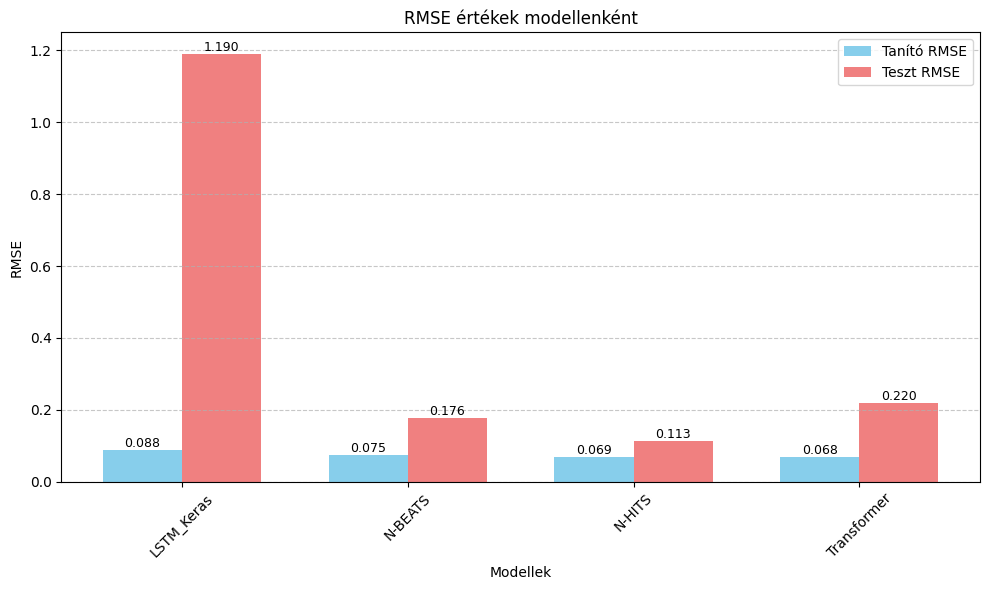

In [10]:
import matplotlib.pyplot as plt
import numpy as np

models = list(results.keys())
train_rmse = [results[model]['train_rmse'] for model in models]
val_rmse = [results[model]['test_rmse'] for model in models]

plt.figure(figsize=(10, 6))

x = np.arange(len(models))
width = 0.35  

bars1 = plt.bar(x - width/2, train_rmse, width, label='Tanító RMSE', color='skyblue')
bars2 = plt.bar(x + width/2, val_rmse, width, label='Teszt RMSE', color='lightcoral')

plt.xlabel('Modellek')
plt.ylabel('RMSE')
plt.title('RMSE értékek modellenként')
plt.xticks(x, models, rotation=45)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

for bar in bars1:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2, height,
        f'{height:.3f}',
        ha='center', va='bottom', fontsize=9
    )

for bar in bars2:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2, height,
        f'{height:.3f}',
        ha='center', va='bottom', fontsize=9
    )

plt.tight_layout()
plt.show()


149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


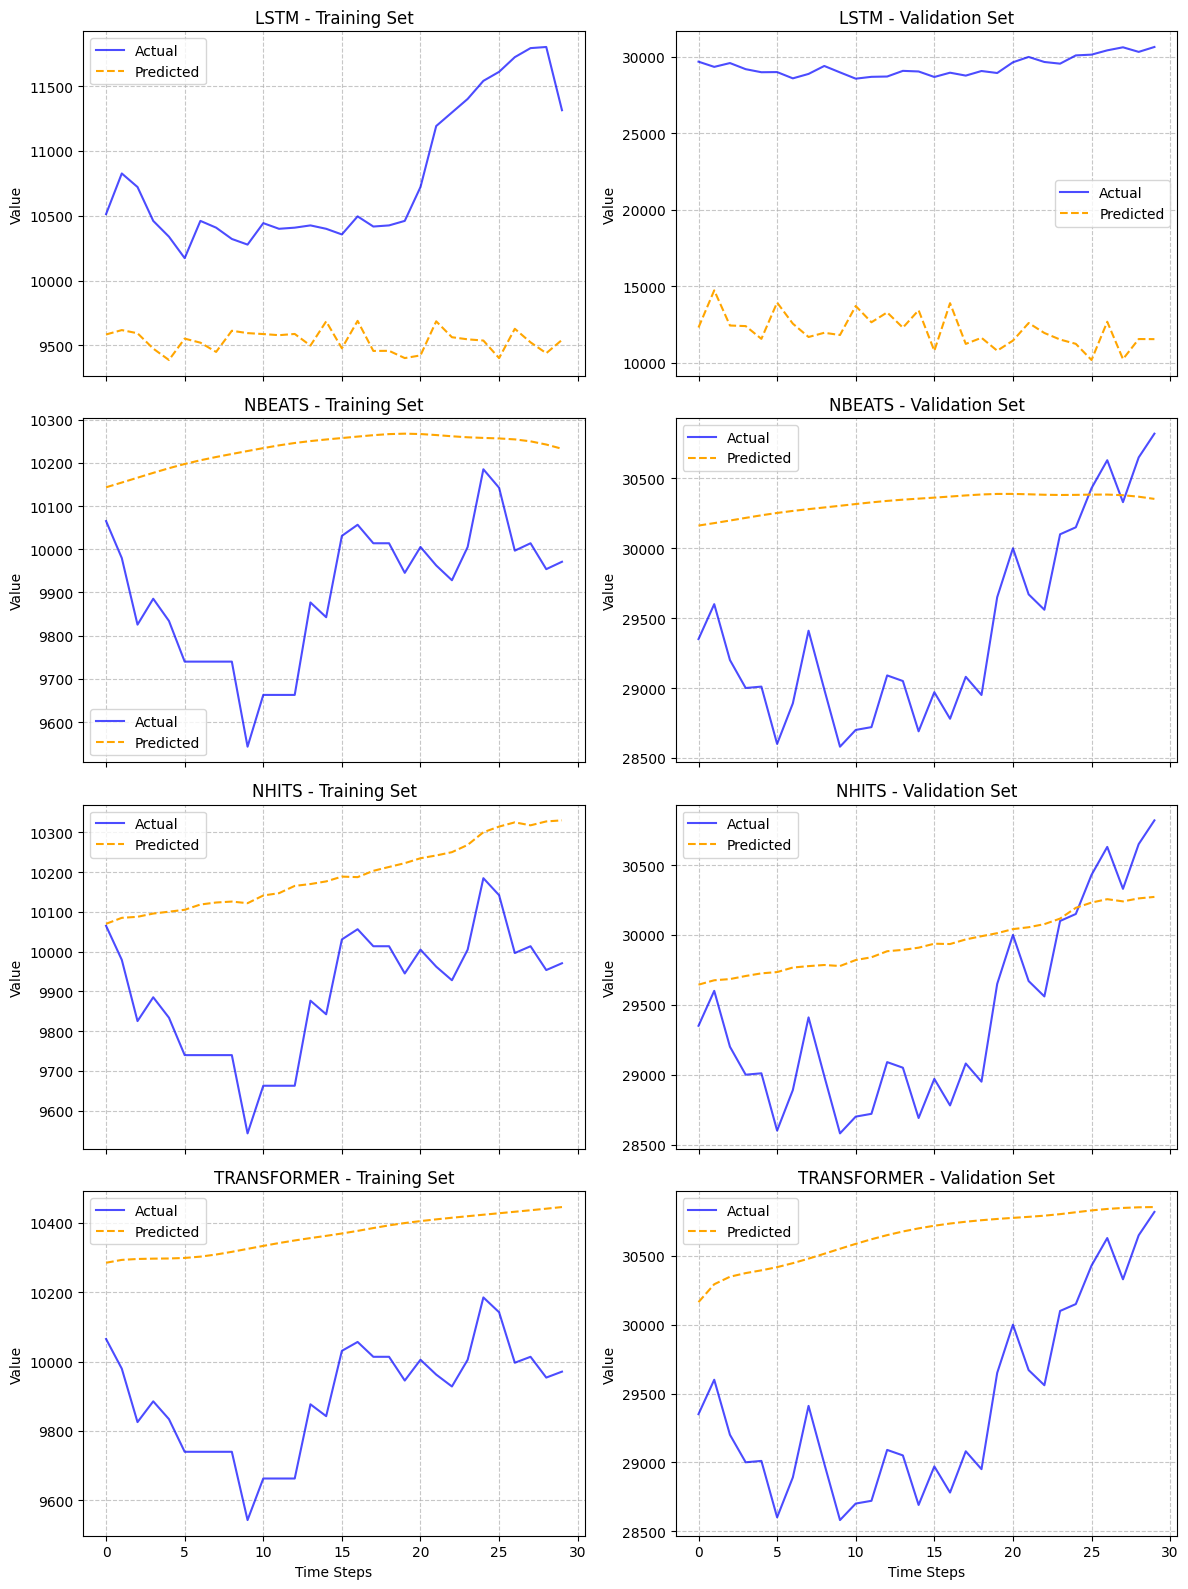

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import joblib

# Assuming model_names is defined as provided
model_names = {"lstm": lstm_model, "nbeats": nbeats_model, "nhits": nhits_model, "transformer": transformer_model}

scaler = joblib.load("../data_pipeline/scaler_model.pkl")

# Initialize dictionaries to store predictions
train_predictions = {}
test_predictions = {}
train_actuals = {}
test_actuals = {}

# Generate predictions for each model
for name in model_names:
    if name == "lstm":
        # LSTM predictions (Keras)
        train_pred = lstm_model.predict(train_X)
        test_pred = lstm_model.predict(test_X)
        # Inverse transform to original scale
        train_predictions[name] = scaler.inverse_transform(train_pred)[-1]
        test_predictions[name] = scaler.inverse_transform(test_pred)[-1]
        train_actuals[name] = scaler.inverse_transform(train_y)[-1]
        test_actuals[name] = scaler.inverse_transform(test_y)[-1]
    else:
        # PyTorch-based models (nbeats, nhits, transformer)
        model = model_names[name]
        # Generate predictions
        train_pred = model.predict(train_dataloader).detach().numpy()
        test_pred = model.predict(test_dataloader).detach().numpy()
        # Get actuals
        train_actual = torch.cat([y[0] for x, y in iter(train_dataloader)]).numpy()
        test_actual = torch.cat([y[0] for x, y in iter(test_dataloader)]).numpy()
        train_predictions[name] = scaler.inverse_transform(train_pred)[-1]
        test_predictions[name] = scaler.inverse_transform(test_pred)[-1]
        train_actuals[name] = scaler.inverse_transform(train_actual)[-1]
        test_actuals[name] = scaler.inverse_transform(test_actual)[-1]

# Set up the figure with subplots for each model
fig, axes = plt.subplots(len(model_names), 2, figsize=(12, 4 * len(model_names)), sharex=True)

# Plot predictions vs actuals for each model
for idx, name in enumerate(model_names):
    # Training set plot
    axes[idx][0].plot(train_actuals[name], label='Actual', color='blue', alpha=0.7)
    axes[idx][0].plot(train_predictions[name], label='Predicted', color='orange', linestyle='--')
    axes[idx][0].set_title(f'{name.upper()} - Training Set')
    axes[idx][0].set_ylabel('Value')
    axes[idx][0].legend()
    axes[idx][0].grid(True, linestyle='--', alpha=0.7)

    # Validation set plot
    axes[idx][1].plot(test_actuals[name], label='Actual', color='blue', alpha=0.7)
    axes[idx][1].plot(test_predictions[name], label='Predicted', color='orange', linestyle='--')
    axes[idx][1].set_title(f'{name.upper()} - Validation Set')
    axes[idx][1].set_ylabel('Value')
    axes[idx][1].legend()
    axes[idx][1].grid(True, linestyle='--', alpha=0.7)

# Set common x-label and adjust layout
for ax in axes[-1]:
    ax.set_xlabel('Time Steps')
plt.tight_layout()

# Show the plot
plt.show()

149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


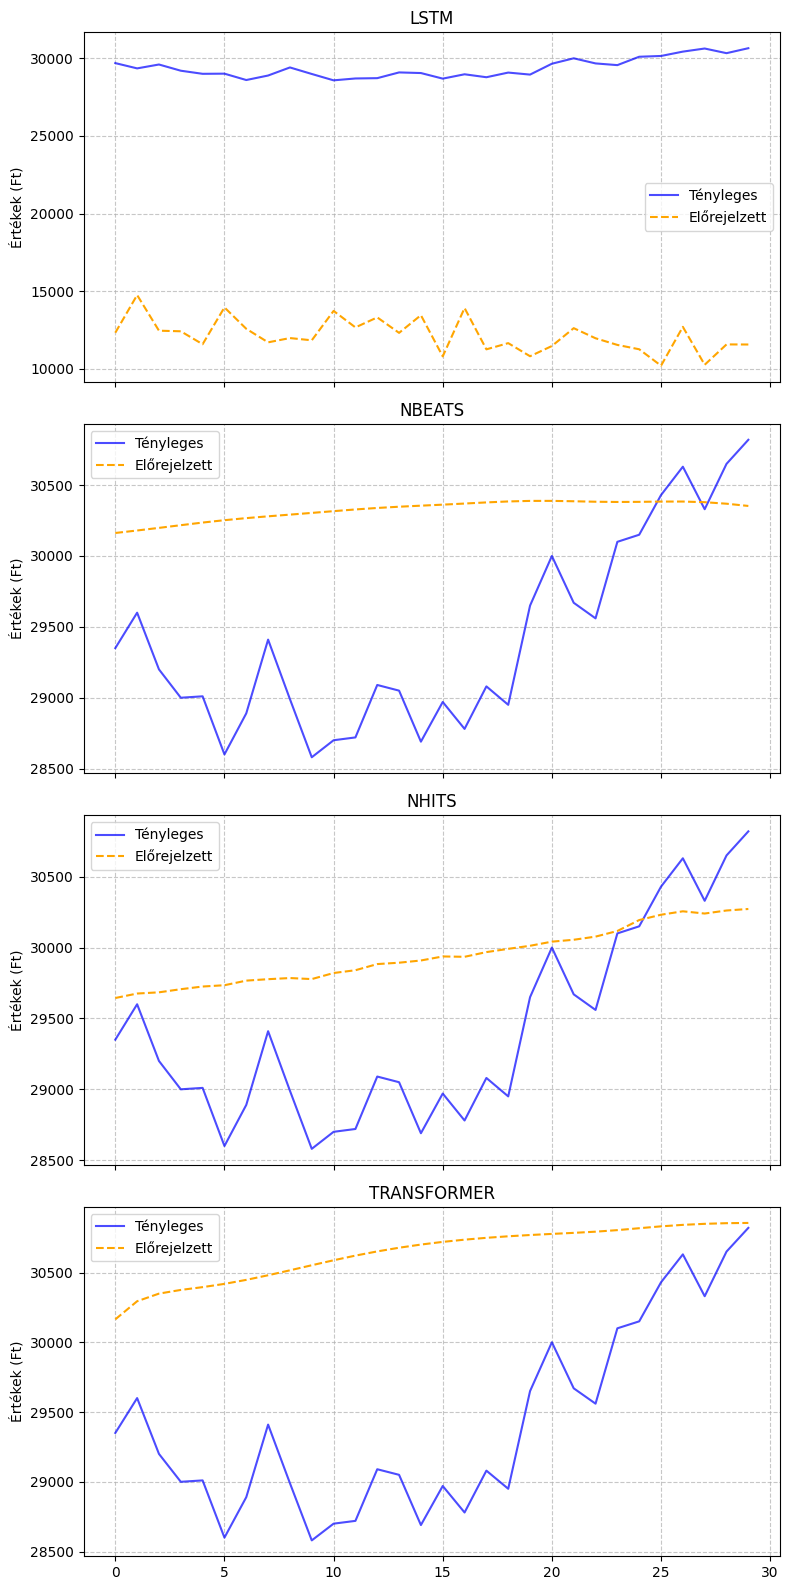

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import joblib

# Assuming model_names is defined as provided
model_names = {"lstm": lstm_model, "nbeats": nbeats_model, "nhits": nhits_model, "transformer": transformer_model}

scaler = joblib.load("../data_pipeline/scaler_model.pkl")

# Initialize dictionaries to store predictions
train_predictions = {}
test_predictions = {}
train_actuals = {}
test_actuals = {}

# Generate predictions for each model
for name in model_names:
    if name == "lstm":
        # LSTM predictions (Keras)
        train_pred = lstm_model.predict(train_X)
        test_pred = lstm_model.predict(test_X)
        # Inverse transform to original scale
        train_predictions[name] = scaler.inverse_transform(train_pred)[-1]
        test_predictions[name] = scaler.inverse_transform(test_pred)[-1]
        train_actuals[name] = scaler.inverse_transform(train_y)[-1]
        test_actuals[name] = scaler.inverse_transform(test_y)[-1]
    else:
        # PyTorch-based models (nbeats, nhits, transformer)
        model = model_names[name]
        # Generate predictions
        train_pred = model.predict(train_dataloader).detach().numpy()
        test_pred = model.predict(test_dataloader).detach().numpy()
        # Get actuals
        train_actual = torch.cat([y[0] for x, y in iter(train_dataloader)]).numpy()
        test_actual = torch.cat([y[0] for x, y in iter(test_dataloader)]).numpy()
        train_predictions[name] = scaler.inverse_transform(train_pred)[-1]
        test_predictions[name] = scaler.inverse_transform(test_pred)[-1]
        train_actuals[name] = scaler.inverse_transform(train_actual)[-1]
        test_actuals[name] = scaler.inverse_transform(test_actual)[-1]

fig, axes = plt.subplots(len(model_names), 1, figsize=(8, 4 * len(model_names)), sharex=True)

for idx, name in enumerate(model_names):

    axes[idx].plot(test_actuals[name], label='Tényleges', color='blue', alpha=0.7)
    axes[idx].plot(test_predictions[name], label='Előrejelzett', color='orange', linestyle='--')
    axes[idx].set_title(f'{name.upper()}')
    axes[idx].set_ylabel('Értékek (Ft)')
    axes[idx].legend()
    axes[idx].grid(True, linestyle='--', alpha=0.7)


plt.tight_layout()

plt.show()

## Újra tanítás a hibák kiértékelése után

In [14]:
from tensorflow.keras.callbacks import EarlyStopping as LSTMEarlyStop

mlflow.set_tracking_uri('http://localhost:5000')

mlflow.set_experiment("Base_models_finetuned")

train_cutoff = int(len(stock_data) * 0.8)
max_encoder_length = 60
max_prediction_length = 30

common_params = dict(
    time_idx="time_idx",
    target="Scaled_price",
    categorical_encoders={"series": NaNLabelEncoder(add_nan=True).fit(stock_data.series)},
    group_ids=["series"],
    time_varying_unknown_reals=["Scaled_price"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
)

train_val_data = stock_data[stock_data.time_idx <= train_cutoff]
test_data = stock_data[stock_data.time_idx > train_cutoff]


val_cutoff = int(train_val_data["time_idx"].quantile(0.9))

train_dataset = TimeSeriesDataSet(
    train_val_data[train_val_data.time_idx <= val_cutoff],
    **common_params
)

val_dataset = TimeSeriesDataSet.from_dataset(
    train_dataset,
    train_val_data[train_val_data.time_idx > val_cutoff],
    predict=True,
    stop_randomization=True
)

test_dataset = TimeSeriesDataSet.from_dataset(
    train_dataset,
    test_data,
    predict=True,
    stop_randomization=True,
    )


train_dataloader = train_dataset.to_dataloader(train=False, batch_size=32, num_workers=0, shuffle=False)
val_dataloader = val_dataset.to_dataloader(train=False, batch_size=32, num_workers=0, shuffle=False)
test_dataloader = test_dataset.to_dataloader(train=False, batch_size=32, num_workers=0, shuffle=False)

models = {
    "LSTM_Keras": None,
    "N-BEATS": NBeats,
    "N-HITS": NHiTS,
    "Transformer": TemporalFusionTransformer
}

results = {}

for model_name, model_class in models.items():
    with mlflow.start_run(run_name=model_name):
        print(f"\n=== Training {model_name} ===")
        if model_name == "LSTM_Keras":
            series = stock_data['Scaled_price'].values

            def create_sequences(series, start_idx, end_idx):
                X, y = [], []
                for i in range(start_idx + max_encoder_length, end_idx - max_prediction_length):
                    X.append(series[i - max_encoder_length:i])
                    y.append(series[i:i + max_prediction_length])
                return np.array(X), np.array(y)

            train_X, train_y = create_sequences(series, 0, train_cutoff)
            val_X, val_y = create_sequences(series, train_cutoff, len(series))

            train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
            val_X = val_X.reshape((val_X.shape[0], val_X.shape[1], 1))

            lstm_model = Sequential([
                Input(shape = (max_encoder_length, 1)),
                LSTM(units = 50, return_sequences = True),
                LSTM(50),
                Dense(max_prediction_length, activation='linear')
            ])
            lstm_model.compile(loss = 'mean_squared_error', optimizer = 'adam')

            early_stopping = LSTMEarlyStop(
                monitor='val_loss',
                patience=20,
                restore_best_weights=True
            )

            lstm_model.fit(train_X, 
                           train_y, 
                           epochs=500, 
                           batch_size=32, 
                           verbose=1, 
                           validation_split=0.1, 
                           callbacks=[early_stopping]
                        )

            train_pred = lstm_model.predict(train_X)
            train_rmse = root_mean_squared_error(train_y, train_pred)

            test_pred = lstm_model.predict(test_X)
            test_rmse = root_mean_squared_error(test_y, test_pred)

            test_mse = mean_squared_error(test_y, test_pred)

            test_mape = mean_absolute_percentage_error(test_y, test_pred)

            mlflow.log_metric("train_rmse", train_rmse)
            mlflow.log_metric("test_rmse", test_rmse)
            mlflow.log_metric("test_mse", test_mse)
            mlflow.log_metric("test_mape", test_mape)
            mlflow.keras.log_model(lstm_model, "model")
            results[model_name] = {'train_rmse': train_rmse, 'test_rmse': test_rmse}
            lstm_model.save('models/lstm_model_base_v2.keras')
        
        elif model_name == "N-BEATS":
            nbeats_model = NBeats.from_dataset(  
                train_dataset,  
                learning_rate=1e-3,  
                weight_decay=1e-3,  
                widths=[256, 512],  
                backcast_loss_ratio=0.1,  
                num_blocks=[4,4], 
                num_block_layers=[4,4],
            )

            early_stopping = EarlyStopping(
                monitor="val_loss",          
                patience=20,                 
                min_delta=1e-4,              
                mode="min", 
                verbose=True
            )

            trainer = Trainer(
                max_epochs=500,
                gradient_clip_val=0.1,
                logger=False,
                enable_checkpointing=False,
                callbacks=[early_stopping]  
            )
            # trainer = Trainer(max_epochs=200, gradient_clip_val=0.1, logger=False, enable_checkpointing=False)
            trainer.fit(nbeats_model, train_dataloader, val_dataloader)

            actuals = torch.cat([y[0] for x, y in iter(train_dataloader)])
            predictions = nbeats_model.predict(train_dataloader)

            test_actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
            test_predictions = nbeats_model.predict(test_dataloader)

            train_rmse = root_mean_squared_error(actuals, predictions[:len(actuals)])
            test_rmse = root_mean_squared_error(test_actuals, test_predictions[:len(test_actuals)])

            test_mse = mean_squared_error(test_actuals, test_predictions[:len(test_actuals)])

            test_mape = mean_absolute_percentage_error(test_actuals, test_predictions[:len(test_actuals)])
            # test_rmse = np.sqrt(torch.mean((test_actuals - test_predictions[:len(test_actuals)]) ** 2)).item()

            total_params = sum(p.numel() for p in nbeats_model.parameters() if p.requires_grad)

            mlflow.log_metric("train_rmse", train_rmse)
            mlflow.log_metric("test_rmse", test_rmse)
            mlflow.log_metric("test_mse", test_mse)
            mlflow.log_metric("test_mape", test_mape)
            mlflow.log_metric("total_parameters", total_params)
            mlflow.pytorch.log_model(nbeats_model, "model")
            results[model_name] = {'train_rmse': train_rmse, 'test_rmse': test_rmse}
            torch.save(nbeats_model.state_dict(), "models/nbeats_weights_base_v2.pth")

        elif model_name == "N-HITS":
            nhits_model = NHiTS.from_dataset(
                train_dataset,
                learning_rate=1e-3,  
                log_interval=10,  
                log_val_interval=1,  
                weight_decay=0.001,  
                n_blocks=[3, 3, 3],  
                n_layers=2,  
                hidden_size=512,  
                dropout=0.1,  
            )

            early_stopping = EarlyStopping(
                monitor="val_loss",          
                patience=20,                 
                min_delta=1e-4,              
                mode="min", 
                verbose=True
            )

            trainer = Trainer(
                max_epochs=500,
                gradient_clip_val=0.1,
                logger=False,
                enable_checkpointing=False,
                callbacks=[early_stopping]  
            )
            # trainer = Trainer(max_epochs=200, gradient_clip_val=0.1, logger=False, enable_checkpointing=False)
            trainer.fit(nhits_model, train_dataloader, val_dataloader)

            actuals = torch.cat([y[0] for x, y in iter(train_dataloader)])
            predictions = nhits_model.predict(train_dataloader)

            test_actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
            test_predictions = nhits_model.predict(test_dataloader)

            train_rmse = root_mean_squared_error(actuals, predictions[:len(actuals)])
            test_rmse = root_mean_squared_error(test_actuals, test_predictions[:len(test_actuals)])

            test_mse = mean_squared_error(test_actuals, test_predictions[:len(test_actuals)])

            test_mape = mean_absolute_percentage_error(test_actuals, test_predictions[:len(test_actuals)])
            # test_rmse = np.sqrt(torch.mean((test_actuals - test_predictions[:len(test_actuals)]) ** 2)).item()

            total_params = sum(p.numel() for p in nhits_model.parameters() if p.requires_grad)

            mlflow.log_metric("train_rmse", train_rmse)
            mlflow.log_metric("test_rmse", test_rmse)
            mlflow.log_metric("test_mse", test_mse)
            mlflow.log_metric("test_mape", test_mape)
            mlflow.log_metric("total_parameters", total_params)
            mlflow.pytorch.log_model(nhits_model, "model")
            results[model_name] = {'train_rmse': train_rmse, 'test_rmse': test_rmse}
            torch.save(nhits_model.state_dict(), "models/nhits_weights_base_v2.pth")

        else:
            transformer_model = TemporalFusionTransformer.from_dataset(
                train_dataset,
                hidden_size=64,
                lstm_layers=1,
                dropout=0.15,
                attention_head_size=4,
                learning_rate=1e-3
            )
            
            early_stopping = EarlyStopping(
                monitor="val_loss",          
                patience=20,                 
                min_delta=1e-4,              
                mode="min", 
                verbose=True
            )

            trainer = Trainer(
                max_epochs=500,
                gradient_clip_val=0.1,
                logger=False,
                enable_checkpointing=False,
                callbacks=[early_stopping]  
            )

            # trainer = Trainer(max_epochs=200, gradient_clip_val=0.1, logger=False, enable_checkpointing=False)
            trainer.fit(transformer_model, train_dataloader, val_dataloader)

            actuals = torch.cat([y[0] for x, y in iter(train_dataloader)])
            predictions = transformer_model.predict(train_dataloader)
            

            test_actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
            test_predictions = transformer_model.predict(test_dataloader)

            train_rmse = root_mean_squared_error(actuals, predictions[:len(actuals)])
            test_rmse = root_mean_squared_error(test_actuals, test_predictions[:len(test_actuals)])

            test_mse = mean_squared_error(test_actuals, test_predictions[:len(test_actuals)])

            test_mape = mean_absolute_percentage_error(test_actuals, test_predictions[:len(test_actuals)])
            # test_rmse = np.sqrt(torch.mean((test_actuals - test_predictions[:len(test_actuals)]) ** 2)).item()

            total_params = sum(p.numel() for p in transformer_model.parameters() if p.requires_grad)

            mlflow.log_metric("train_rmse", train_rmse)
            mlflow.log_metric("test_rmse", test_rmse)
            mlflow.log_metric("test_mse", test_mse)
            mlflow.log_metric("test_mape", test_mape)
            mlflow.log_metric("total_parameters", total_params)
            mlflow.pytorch.log_model(transformer_model, "model")
            results[model_name] = {'train_rmse': train_rmse, 'test_rmse': test_rmse}
            torch.save(transformer_model.state_dict(), "models/transformer_weights_base_v2.pth")

print("\n=== RMSE Results ===")
for model_name, rmse_values in results.items():
    print(f"{model_name} => Train RMSE: {rmse_values['train_rmse']:.4f}, Test RMSE: {rmse_values['test_rmse']:.4f}")



=== Training LSTM_Keras ===
Epoch 1/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0385 - val_loss: 0.0919
Epoch 2/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0057 - val_loss: 0.0708
Epoch 3/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0054 - val_loss: 0.0658
Epoch 4/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0051 - val_loss: 0.0690
Epoch 5/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0050 - val_loss: 0.0640
Epoch 6/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0049 - val_loss: 0.0616
Epoch 7/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0049 - val_loss: 0.0531
Epoch 8/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0049 - val_loss: 0.0587
Epoch 9/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0047 - val_loss: 0.0559
Epoch 10/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0047 - val_loss: 0.0519
Epoch 11/500
134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0046 - val_loss: 0.0564
E

2025/11/06 18:26:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/06 18:26:41 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/11/06 18:26:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
I

🏃 View run LSTM_Keras at: http://localhost:5000/#/experiments/701803511120156103/runs/2775bffa9f964491a73e37b0d9184af1
🧪 View experiment at: http://localhost:5000/#/experiments/701803511120156103

=== Training N-BEATS ===
                                                                           

c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 134/134 [00:06<00:00, 20.36it/s, train_loss_step=1.980, val_loss=4.960, train_loss_epoch=5.040]

Metric val_loss improved. New best score: 4.961


Epoch 1: 100%|██████████| 134/134 [00:06<00:00, 20.03it/s, train_loss_step=2.850, val_loss=4.480, train_loss_epoch=4.750]

Metric val_loss improved by 0.478 >= min_delta = 0.0001. New best score: 4.483


Epoch 2: 100%|██████████| 134/134 [00:06<00:00, 20.26it/s, train_loss_step=3.160, val_loss=3.810, train_loss_epoch=4.550]

Metric val_loss improved by 0.669 >= min_delta = 0.0001. New best score: 3.815


Epoch 3: 100%|██████████| 134/134 [00:06<00:00, 20.11it/s, train_loss_step=2.970, val_loss=3.460, train_loss_epoch=4.420]

Metric val_loss improved by 0.358 >= min_delta = 0.0001. New best score: 3.457


Epoch 4: 100%|██████████| 134/134 [00:06<00:00, 20.31it/s, train_loss_step=2.040, val_loss=3.450, train_loss_epoch=4.220]

Metric val_loss improved by 0.009 >= min_delta = 0.0001. New best score: 3.448


Epoch 5: 100%|██████████| 134/134 [00:06<00:00, 20.22it/s, train_loss_step=2.660, val_loss=3.150, train_loss_epoch=4.380]

Metric val_loss improved by 0.298 >= min_delta = 0.0001. New best score: 3.150


Epoch 8: 100%|██████████| 134/134 [00:06<00:00, 20.07it/s, train_loss_step=2.810, val_loss=2.890, train_loss_epoch=4.220]

Metric val_loss improved by 0.260 >= min_delta = 0.0001. New best score: 2.890


Epoch 28: 100%|██████████| 134/134 [00:06<00:00, 19.28it/s, train_loss_step=2.280, val_loss=4.350, train_loss_epoch=4.110]

Monitored metric val_loss did not improve in the last 20 records. Best score: 2.890. Signaling Trainer to stop.


Epoch 28: 100%|██████████| 134/134 [00:06<00:00, 19.27it/s, train_loss_step=2.280, val_loss=4.350, train_loss_epoch=4.110]


c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
2025/11/06 18:30:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/06 18:30:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\utilities\

🏃 View run N-BEATS at: http://localhost:5000/#/experiments/701803511120156103/runs/51ca4b42e4c945f1ac32d21fc106e619
🧪 View experiment at: http://localhost:5000/#/experiments/701803511120156103

=== Training N-HITS ===
                                                                           

c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 134/134 [00:05<00:00, 25.19it/s, train_loss_step=3.590, val_loss=2.610, train_loss_epoch=4.690]

Metric val_loss improved. New best score: 2.609


Epoch 20: 100%|██████████| 134/134 [00:05<00:00, 25.55it/s, train_loss_step=2.340, val_loss=3.350, train_loss_epoch=3.920]

Monitored metric val_loss did not improve in the last 20 records. Best score: 2.609. Signaling Trainer to stop.


Epoch 20: 100%|██████████| 134/134 [00:05<00:00, 25.54it/s, train_loss_step=2.340, val_loss=3.350, train_loss_epoch=3.920]


c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
2025/11/06 18:32:17 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/06 18:32:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\utilities\

🏃 View run N-HITS at: http://localhost:5000/#/experiments/701803511120156103/runs/ab5d93545b384f66a01dbd8fef0e99fc
🧪 View experiment at: http://localhost:5000/#/experiments/701803511120156103

=== Training Transformer ===
                                                                           

c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 134/134 [00:11<00:00, 11.20it/s, train_loss_step=0.0308, val_loss=0.0869, train_loss_epoch=0.0362]

Metric val_loss improved. New best score: 0.087


Epoch 1: 100%|██████████| 134/134 [00:11<00:00, 11.26it/s, train_loss_step=0.030, val_loss=0.0837, train_loss_epoch=0.0296] 

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.084


Epoch 2: 100%|██████████| 134/134 [00:12<00:00, 10.92it/s, train_loss_step=0.0294, val_loss=0.0806, train_loss_epoch=0.0285]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.081


Epoch 3: 100%|██████████| 134/134 [00:12<00:00, 10.59it/s, train_loss_step=0.030, val_loss=0.0787, train_loss_epoch=0.0279] 

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.079


Epoch 4: 100%|██████████| 134/134 [00:12<00:00, 10.66it/s, train_loss_step=0.030, val_loss=0.0761, train_loss_epoch=0.0273] 

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.076


Epoch 5: 100%|██████████| 134/134 [00:12<00:00, 10.74it/s, train_loss_step=0.0303, val_loss=0.075, train_loss_epoch=0.0271] 

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.075


Epoch 6: 100%|██████████| 134/134 [00:12<00:00, 11.11it/s, train_loss_step=0.0302, val_loss=0.0741, train_loss_epoch=0.0269]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.074


Epoch 7: 100%|██████████| 134/134 [00:12<00:00, 11.11it/s, train_loss_step=0.0308, val_loss=0.0718, train_loss_epoch=0.0266]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.072


Epoch 9: 100%|██████████| 134/134 [00:11<00:00, 11.24it/s, train_loss_step=0.0311, val_loss=0.070, train_loss_epoch=0.0261] 

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.070


Epoch 10: 100%|██████████| 134/134 [00:12<00:00, 11.10it/s, train_loss_step=0.0318, val_loss=0.0687, train_loss_epoch=0.026] 

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.069


Epoch 11: 100%|██████████| 134/134 [00:11<00:00, 11.28it/s, train_loss_step=0.0314, val_loss=0.0681, train_loss_epoch=0.0259]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.068


Epoch 14: 100%|██████████| 134/134 [00:12<00:00, 11.11it/s, train_loss_step=0.031, val_loss=0.0666, train_loss_epoch=0.0257] 

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.067


Epoch 15: 100%|██████████| 134/134 [00:11<00:00, 11.24it/s, train_loss_step=0.0311, val_loss=0.0659, train_loss_epoch=0.0255]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.066


Epoch 16: 100%|██████████| 134/134 [00:12<00:00, 11.14it/s, train_loss_step=0.0295, val_loss=0.0635, train_loss_epoch=0.0254]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.064


Epoch 17: 100%|██████████| 134/134 [00:11<00:00, 11.27it/s, train_loss_step=0.0287, val_loss=0.0632, train_loss_epoch=0.0254]

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.063


Epoch 18: 100%|██████████| 134/134 [00:12<00:00, 11.13it/s, train_loss_step=0.0303, val_loss=0.0612, train_loss_epoch=0.0253]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.061


Epoch 19: 100%|██████████| 134/134 [00:11<00:00, 11.29it/s, train_loss_step=0.0292, val_loss=0.0593, train_loss_epoch=0.0252]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.059


Epoch 20: 100%|██████████| 134/134 [00:12<00:00, 11.07it/s, train_loss_step=0.0292, val_loss=0.0573, train_loss_epoch=0.0252]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.057


Epoch 21: 100%|██████████| 134/134 [00:11<00:00, 11.29it/s, train_loss_step=0.0277, val_loss=0.0569, train_loss_epoch=0.0251]

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.057


Epoch 22: 100%|██████████| 134/134 [00:12<00:00, 11.10it/s, train_loss_step=0.0288, val_loss=0.056, train_loss_epoch=0.0251] 

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.056


Epoch 23: 100%|██████████| 134/134 [00:11<00:00, 11.23it/s, train_loss_step=0.029, val_loss=0.0543, train_loss_epoch=0.025] 

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.054


Epoch 24: 100%|██████████| 134/134 [00:12<00:00, 11.05it/s, train_loss_step=0.0285, val_loss=0.052, train_loss_epoch=0.025] 

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.052


Epoch 25: 100%|██████████| 134/134 [00:11<00:00, 11.26it/s, train_loss_step=0.0277, val_loss=0.0512, train_loss_epoch=0.0248]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.051


Epoch 26: 100%|██████████| 134/134 [00:12<00:00, 11.04it/s, train_loss_step=0.0282, val_loss=0.0491, train_loss_epoch=0.0248]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.049


Epoch 27: 100%|██████████| 134/134 [00:11<00:00, 11.29it/s, train_loss_step=0.0281, val_loss=0.0477, train_loss_epoch=0.0247]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.048


Epoch 28: 100%|██████████| 134/134 [00:12<00:00, 11.06it/s, train_loss_step=0.0285, val_loss=0.0464, train_loss_epoch=0.0246]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.046


Epoch 30: 100%|██████████| 134/134 [00:12<00:00, 11.12it/s, train_loss_step=0.0285, val_loss=0.0448, train_loss_epoch=0.0246]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.045


Epoch 31: 100%|██████████| 134/134 [00:11<00:00, 11.21it/s, train_loss_step=0.0274, val_loss=0.0442, train_loss_epoch=0.0245]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.044


Epoch 35: 100%|██████████| 134/134 [00:11<00:00, 11.20it/s, train_loss_step=0.0276, val_loss=0.044, train_loss_epoch=0.024]  

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.044


Epoch 38: 100%|██████████| 134/134 [00:12<00:00, 11.17it/s, train_loss_step=0.0291, val_loss=0.0436, train_loss_epoch=0.0238]

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.044


Epoch 41: 100%|██████████| 134/134 [00:11<00:00, 11.37it/s, train_loss_step=0.027, val_loss=0.0412, train_loss_epoch=0.0235] 

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.041


Epoch 42: 100%|██████████| 134/134 [00:11<00:00, 11.23it/s, train_loss_step=0.0287, val_loss=0.0407, train_loss_epoch=0.0235]

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.041


Epoch 47: 100%|██████████| 134/134 [00:11<00:00, 11.31it/s, train_loss_step=0.0273, val_loss=0.0356, train_loss_epoch=0.023] 

Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 0.036


Epoch 50: 100%|██████████| 134/134 [00:12<00:00, 11.11it/s, train_loss_step=0.027, val_loss=0.0354, train_loss_epoch=0.0228]  

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.035


Epoch 52: 100%|██████████| 134/134 [00:12<00:00, 11.14it/s, train_loss_step=0.0258, val_loss=0.0348, train_loss_epoch=0.0223] 

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.035


Epoch 53: 100%|██████████| 134/134 [00:12<00:00, 11.12it/s, train_loss_step=0.0256, val_loss=0.0333, train_loss_epoch=0.0223] 

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.033


Epoch 55: 100%|██████████| 134/134 [00:11<00:00, 11.40it/s, train_loss_step=0.0249, val_loss=0.0315, train_loss_epoch=0.022]  

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.031


Epoch 75: 100%|██████████| 134/134 [00:12<00:00, 11.06it/s, train_loss_step=0.0219, val_loss=0.0382, train_loss_epoch=0.0191] 

Monitored metric val_loss did not improve in the last 20 records. Best score: 0.031. Signaling Trainer to stop.


Epoch 75: 100%|██████████| 134/134 [00:12<00:00, 11.06it/s, train_loss_step=0.0219, val_loss=0.0382, train_loss_epoch=0.0191]


c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
2025/11/06 18:47:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/06 18:47:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Transformer at: http://localhost:5000/#/experiments/701803511120156103/runs/b09047d1113f4f208894c090f7509f75
🧪 View experiment at: http://localhost:5000/#/experiments/701803511120156103

=== RMSE Results ===
LSTM_Keras => Train RMSE: 0.0833, Test RMSE: 1.0256
N-BEATS => Train RMSE: 0.0686, Test RMSE: 0.1403
N-HITS => Train RMSE: 0.0628, Test RMSE: 0.1038
Transformer => Train RMSE: 0.0524, Test RMSE: 0.1232


In [25]:
print("\n=== RMSE Results ===")
for model_name, rmse_values in results.items():
    print(f"{model_name} => Train RMSE: {rmse_values['train_rmse']:.4f}, Test RMSE: {rmse_values['test_rmse']:.4f}")


=== RMSE Results ===
LSTM_Keras => Train RMSE: 0.0815, Test RMSE: 0.9502
N-BEATS => Train RMSE: 0.6875, Test RMSE: 0.2038
N-HITS => Train RMSE: 0.6980, Test RMSE: 0.1998
Transformer => Train RMSE: 0.7004, Test RMSE: 0.2409


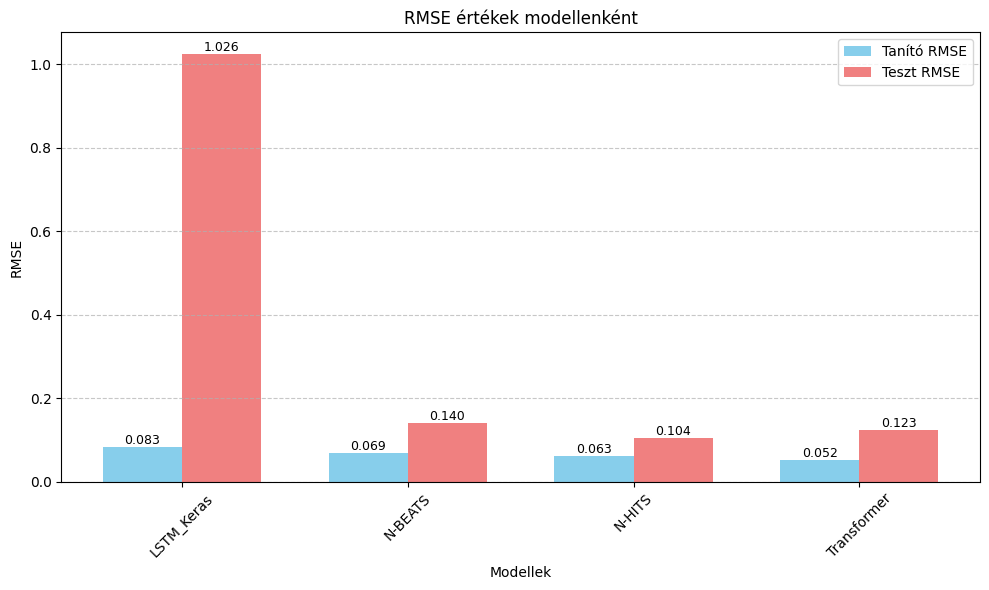

In [15]:
import matplotlib.pyplot as plt
import numpy as np

models = list(results.keys())
train_rmse = [results[model]['train_rmse'] for model in models]
val_rmse = [results[model]['test_rmse'] for model in models]

plt.figure(figsize=(10, 6))

x = np.arange(len(models))
width = 0.35  

bars1 = plt.bar(x - width/2, train_rmse, width, label='Tanító RMSE', color='skyblue')
bars2 = plt.bar(x + width/2, val_rmse, width, label='Teszt RMSE', color='lightcoral')

plt.xlabel('Modellek')
plt.ylabel('RMSE')
plt.title('RMSE értékek modellenként')
plt.xticks(x, models, rotation=45)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

for bar in bars1:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2, height,
        f'{height:.3f}',
        ha='center', va='bottom', fontsize=9
    )

for bar in bars2:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2, height,
        f'{height:.3f}',
        ha='center', va='bottom', fontsize=9
    )

plt.tight_layout()
plt.show()


149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


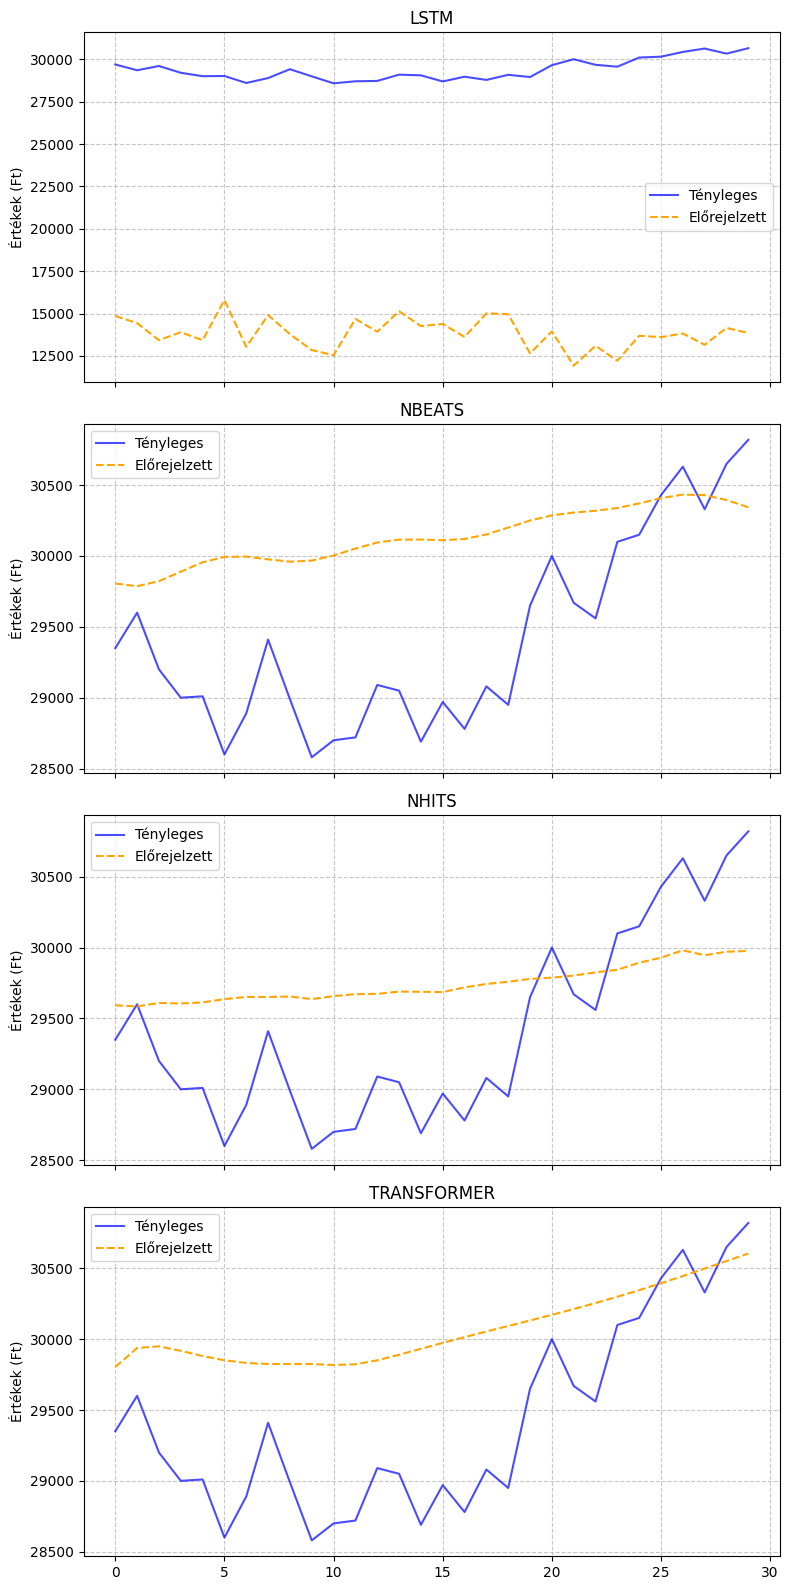

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import joblib

# Assuming model_names is defined as provided
model_names = {"lstm": lstm_model, "nbeats": nbeats_model, "nhits": nhits_model, "transformer": transformer_model}

scaler = joblib.load("../data_pipeline/scaler_model.pkl")

# Initialize dictionaries to store predictions
train_predictions = {}
test_predictions = {}
train_actuals = {}
test_actuals = {}

# Generate predictions for each model
for name in model_names:
    if name == "lstm":
        # LSTM predictions (Keras)
        train_pred = lstm_model.predict(train_X)
        test_pred = lstm_model.predict(test_X)
        # Inverse transform to original scale
        train_predictions[name] = scaler.inverse_transform(train_pred)[-1]
        test_predictions[name] = scaler.inverse_transform(test_pred)[-1]
        train_actuals[name] = scaler.inverse_transform(train_y)[-1]
        test_actuals[name] = scaler.inverse_transform(test_y)[-1]
    else:
        # PyTorch-based models (nbeats, nhits, transformer)
        model = model_names[name]
        # Generate predictions
        train_pred = model.predict(train_dataloader).detach().numpy()
        test_pred = model.predict(test_dataloader).detach().numpy()
        # Get actuals
        train_actual = torch.cat([y[0] for x, y in iter(train_dataloader)]).numpy()
        test_actual = torch.cat([y[0] for x, y in iter(test_dataloader)]).numpy()
        train_predictions[name] = scaler.inverse_transform(train_pred)[-1]
        test_predictions[name] = scaler.inverse_transform(test_pred)[-1]
        train_actuals[name] = scaler.inverse_transform(train_actual)[-1]
        test_actuals[name] = scaler.inverse_transform(test_actual)[-1]

fig, axes = plt.subplots(len(model_names), 1, figsize=(8, 4 * len(model_names)), sharex=True)

for idx, name in enumerate(model_names):

    axes[idx].plot(test_actuals[name], label='Tényleges', color='blue', alpha=0.7)
    axes[idx].plot(test_predictions[name], label='Előrejelzett', color='orange', linestyle='--')
    axes[idx].set_title(f'{name.upper()}')
    axes[idx].set_ylabel('Értékek (Ft)')
    axes[idx].legend()
    axes[idx].grid(True, linestyle='--', alpha=0.7)


plt.tight_layout()

plt.show()

In [32]:

conn = sqlite3.connect("../data_pipeline/stock_data.db")

stock_data = pd.read_sql("SELECT * FROM OTP_BD", conn)
conn.close()

print("Data read back from SQL:")
print()
stock_data

Data read back from SQL:



,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Scaled_price,sentiment_score
0,2002-03-05,1346.679102,1404.393921,1335.136138,1404.393921,1726700,0.0,0.0,-1.009421,0.0
1,2002-03-06,1396.057389,1443.511797,1379.384219,1436.457764,898300,0.0,0.0,-1.003618,0.0
2,2002-03-07,1449.924288,1474.934039,1437.098775,1471.727661,763700,0.0,0.0,-0.997235,0.0
3,2002-03-08,1452.489264,1463.390950,1438.381201,1462.108398,402000,0.0,0.0,-0.998976,1.0
4,2002-03-11,1445.435476,1448.641854,1379.384076,1384.514282,439600,0.0,0.0,-1.013019,1.0
...,...,...,...,...,...,...,...,...,...,...
6040,2025-10-15,30200.000000,30640.000000,30200.000000,30430.000000,333078,0.0,0.0,4.243485,2.0
6041,2025-10-16,30450.000000,30780.000000,30360.000000,30630.000000,290776,0.0,0.0,4.279680,1.0
6042,2025-10-17,30350.000000,30480.000000,30130.000000,30330.000000,268702,0.0,0.0,4.225388,2.0
6043,2025-10-20,30410.000000,30750.000000,30410.000000,30650.000000,166529,0.0,0.0,4.283300,0.0


In [81]:
test_set = stock_data[-90:]

test_X = test_set["Scaled_price"][:60].values

real_prices = test_set["Close"][-30:].values

In [58]:
stock_data['time_idx'] = range(len(stock_data))

stock_data["series"] = 0

In [59]:
common_params = dict(
    time_idx="time_idx",
    target="Scaled_price",
    categorical_encoders={"series": NaNLabelEncoder(add_nan=True).fit(stock_data.series)},
    group_ids=["series"],
    time_varying_unknown_reals=["Scaled_price"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
)

In [60]:
test_dataset = TimeSeriesDataSet(
    test_set,
    **common_params
)

test_dataloader = test_dataset.to_dataloader(train=False, batch_size=32, num_workers=0, shuffle=False)

In [76]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import joblib

# Define models
model_names = {
    "lstm": lstm_model,
    "nbeats": nbeats_model,
    "nhits": nhits_model,
    "transformer": transformer_model
}

scaler = joblib.load("../data_pipeline/scaler_model.pkl")

test_predictions = {}
# test_actuals = {}

for name in model_names:
    if name == "lstm":
        test_pred = lstm_model.predict(test_X.reshape(1, 60, 1))
        test_predictions[name] = scaler.inverse_transform(test_pred)

    else:
        model = model_names[name]
        # print(model)
        test_pred = model.predict(test_dataloader).detach().numpy()

        test_predictions[name] = scaler.inverse_transform(test_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


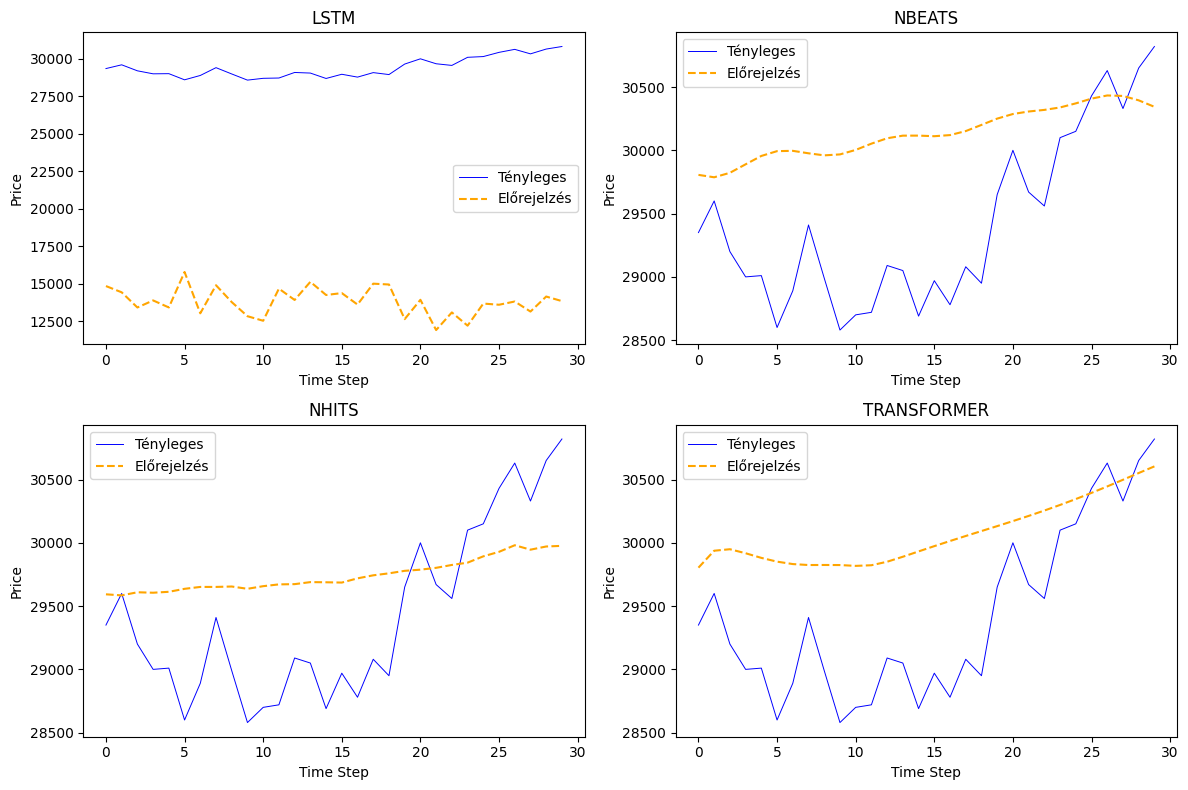


📊 Model Performance Comparison:
                      MSE      RMSE  MAPE (%)
Model                                        
LSTM         2.445224e+08  15637.21     52.94
NBEATS       8.000748e+05    894.47      2.67
NHITS        4.186284e+05    647.01      1.96
TRANSFORMER  6.221111e+05    788.74      2.34


In [84]:
pred_df = pd.DataFrame({model: preds.flatten() for model, preds in test_predictions.items()})
pred_df['real'] = real_prices

# Plot each model vs real
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, (model, preds) in enumerate(test_predictions.items()):
    ax = axes[i]
    ax.plot(real_prices, label='Tényleges', color='blue', linewidth=0.7)
    ax.plot(preds.flatten(), label=f'Előrejelzés', color='orange', linestyle='--')
    ax.set_title(model.upper())
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Price')
    ax.legend()

plt.tight_layout()
plt.show()

# Calculate metrics
results = []
for model, preds in test_predictions.items():
    y_pred = preds.flatten()
    mse = mean_squared_error(real_prices, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(real_prices, y_pred) * 100
    results.append({'Model': model.upper(), 'MSE': mse, 'RMSE': rmse, 'MAPE (%)': mape})

# Create results table
results_df = pd.DataFrame(results).set_index('Model')
print("\n📊 Model Performance Comparison:")
print(results_df.round(2))

In [86]:
for model, preds in test_predictions.items():
    y_pred = preds.flatten()
    mse = mean_squared_error(real_prices, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(real_prices, y_pred) * 100
    print(model, mse)

lstm 244522387.56174803
nbeats 800074.748097229
nhits 418628.36071128846
transformer 622111.1311885833


# Tanítás hírek használatával

In [13]:
import torch
from pytorch_forecasting.models.nbeats import NBeats
from pytorch_forecasting.models.nhits import NHiTS
from pytorch_forecasting.models.temporal_fusion_transformer import TemporalFusionTransformer
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.data.encoders import NaNLabelEncoder
from sklearn.preprocessing import StandardScaler
from pytorch_forecasting import TimeSeriesDataSet, NHiTS, NBeats, TemporalFusionTransformer
import sqlite3
import os
import mlflow
import pandas as pd
import numpy as np
import torch
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from pytorch_forecasting.data import GroupNormalizer
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping

import time

import numpy as np

import matplotlib.pyplot as plt

SENTIMENT_LABEL_MAPPING = {0 : "positive", 1 : "negative", 2: "neutral"}

In [15]:

conn = sqlite3.connect("../data_pipeline/stock_data.db")

stock_data = pd.read_sql("SELECT * FROM OTP_BD", conn)
conn.close()

print("Data read back from SQL:")
print()
stock_data

Data read back from SQL:



,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Scaled_price,sentiment_score
0,2002-03-05,1346.679102,1404.393921,1335.136138,1404.393921,1726700,0.0,0.0,-1.009421,0.0
1,2002-03-06,1396.057389,1443.511797,1379.384219,1436.457764,898300,0.0,0.0,-1.003618,0.0
2,2002-03-07,1449.924288,1474.934039,1437.098775,1471.727661,763700,0.0,0.0,-0.997235,0.0
3,2002-03-08,1452.489264,1463.390950,1438.381201,1462.108398,402000,0.0,0.0,-0.998976,1.0
4,2002-03-11,1445.435476,1448.641854,1379.384076,1384.514282,439600,0.0,0.0,-1.013019,1.0
...,...,...,...,...,...,...,...,...,...,...
6040,2025-10-15,30200.000000,30640.000000,30200.000000,30430.000000,333078,0.0,0.0,4.243485,2.0
6041,2025-10-16,30450.000000,30780.000000,30360.000000,30630.000000,290776,0.0,0.0,4.279680,1.0
6042,2025-10-17,30350.000000,30480.000000,30130.000000,30330.000000,268702,0.0,0.0,4.225388,2.0
6043,2025-10-20,30410.000000,30750.000000,30410.000000,30650.000000,166529,0.0,0.0,4.283300,0.0


In [16]:
stock_data['Sentiment_labels'] = stock_data['sentiment_score'].map(SENTIMENT_LABEL_MAPPING)

In [17]:
stock_data['time_idx'] = range(len(stock_data))

stock_data["series"] = 0

In [ ]:
mlflow.set_tracking_uri('http://localhost:5000')

mlflow.set_experiment("Base_models_sentiment")


train_cutoff = int(len(stock_data) * 0.8)
max_encoder_length = 60
max_prediction_length = 30

common_params = dict(
    time_idx="time_idx",
    target="Scaled_price",
    categorical_encoders={"series": NaNLabelEncoder(add_nan=True).fit(stock_data.series)},
    group_ids=["series"],
    time_varying_unknown_reals=["Scaled_price"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    time_varying_unknown_categoricals =["Sentiment_labels"]
)

train_val_data = stock_data[stock_data.time_idx <= train_cutoff]
test_data = stock_data[stock_data.time_idx > train_cutoff]


val_cutoff = int(train_val_data["time_idx"].quantile(0.9)) 

train_dataset = TimeSeriesDataSet(
    train_val_data[train_val_data.time_idx <= val_cutoff],
    **common_params
)

val_dataset = TimeSeriesDataSet.from_dataset(
    train_dataset,
    train_val_data[train_val_data.time_idx > val_cutoff],
    predict=True,
    stop_randomization=True
)

test_dataset = TimeSeriesDataSet.from_dataset(
    train_dataset,
    test_data,
    predict=True,
    stop_randomization=True
)


train_dataloader = train_dataset.to_dataloader(train=True, batch_size=32, num_workers=0)
val_dataloader = val_dataset.to_dataloader(train=False, batch_size=32, num_workers=0)
test_dataloader = test_dataset.to_dataloader(train=False, batch_size=32, num_workers=0)

models = {
    "LSTM_Keras": None,
    "N-BEATS": NBeats,
    "N-HITS": NHiTS,
    "Transformer": TemporalFusionTransformer
}

results = {}

test_actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])

for model_name, model_class in models.items():
    with mlflow.start_run(run_name=model_name):
        print(f"\n=== Training {model_name} ===")
        if model_name == "LSTM_Keras":
            feature_columns = ['Scaled_price', 'sentiment_score']
            data_features = stock_data[feature_columns].values
            target_column = stock_data['Scaled_price'].values

            n_features = data_features.shape[1] 
            print(f"Using {n_features} features")

            def create_sequences(input_data, output_data, start_idx, end_idx):
                X, y = [], []
                for i in range(start_idx + max_encoder_length, end_idx - max_prediction_length):
                    X.append(input_data[i - max_encoder_length:i, :]) 
                    
                    y.append(output_data[i:i + max_prediction_length])
                    
                return np.array(X), np.array(y)

            train_X, train_y = create_sequences(data_features, target_column, 0, train_cutoff)
            test_X, test_y = create_sequences(data_features, target_column, train_cutoff, len(data_features))

            lstm_model = Sequential([
                Input(shape = (max_encoder_length, n_features)),
                LSTM(units = 50, return_sequences = True),
                LSTM(50),
                Dense(max_prediction_length, activation='linear')
            ])
            lstm_model.compile(loss = 'mean_squared_error', optimizer = 'adam')
            lstm_model.fit(train_X, train_y,  epochs=15, batch_size=20, 
                    verbose=1, validation_split=0.1,)

            train_pred = lstm_model.predict(train_X)
            train_rmse = mean_squared_error(train_y, train_pred)

            test_pred = lstm_model.predict(test_X)
            test_rmse = mean_squared_error(test_y, test_pred)

            mlflow.log_metric("train_rmse", train_rmse)
            mlflow.log_metric("test_rmse", test_rmse)
            mlflow.keras.log_model(lstm_model, "model")
            results[model_name] = {'train_rmse': train_rmse, 'test_rmse': test_rmse}
            lstm_model.save('models/lstm_model_sentiment.keras')
        
        elif model_name == "N-BEATS":
        #     nbeats_model = NBeats.from_dataset(  
        #         train_dataset,  
        #         learning_rate=1e-3,  
        #         weight_decay=1e-3,  
        #         widths=[256, 512],  
        #         backcast_loss_ratio=0.1,  
        #         num_blocks=[4,4],  
        #         num_block_layers=[4,4], 
        #     )
        #     trainer = Trainer(max_epochs=20, gradient_clip_val=0.1, logger=False, enable_checkpointing=False)
        #     trainer.fit(nbeats_model, train_dataloader)

        #     actuals = torch.cat([y[0] for x, y in iter(train_dataloader)])
        #     predictions = nbeats_model.predict(train_dataloader)
        #     train_rmse = root_mean_squared_error(actuals, predictions[:len(actuals)])

        #     test_actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
        #     test_predictions = nbeats_model.predict(val_dataloader)
        #     test_rmse = root_mean_squared_error(test_actuals, test_predictions[:len(test_actuals)])

        #     test_mse = mean_squared_error(test_actuals, test_predictions[:len(test_actuals)])

        #     test_mape = mean_absolute_percentage_error(test_actuals, test_predictions[:len(test_actuals)])

        #     total_params = sum(p.numel() for p in nbeats_model.parameters() if p.requires_grad)

        #     mlflow.log_metric("train_rmse", train_rmse)
        #     mlflow.log_metric("test_rmse", test_rmse)
        #     mlflow.log_metric("test_mse", test_mse)
        #     mlflow.log_metric("test_mape", test_mape)
        #     mlflow.log_metric("total_parameters", total_params)
        #     mlflow.pytorch.log_model(nbeats_model, "model")
            results[model_name] = {'train_rmse': 0, 'test_rmse': 0}
        #     torch.save(nbeats_model.state_dict(), "models/nbeats_weights_sentiment.pth")

        elif model_name == "N-HITS":
            nhits_model = NHiTS.from_dataset(
                train_dataset,
                learning_rate=1e-3,  
                log_interval=10,  
                log_val_interval=1,  
                weight_decay=0.001,  
                n_blocks=[3, 3, 3],  
                n_layers=2,  
                hidden_size=512,  
                dropout=0.1,  
            )
            trainer = Trainer(max_epochs=20, gradient_clip_val=0.1, logger=False, enable_checkpointing=False)
            trainer.fit(nhits_model, train_dataloader, val_dataloader)

            actuals = torch.cat([y[0] for x, y in iter(train_dataloader)])
            predictions = nhits_model.predict(train_dataloader)

            test_actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
            test_predictions = nhits_model.predict(test_dataloader)

            train_rmse = root_mean_squared_error(actuals, predictions[:len(actuals)])
            test_rmse = root_mean_squared_error(test_actuals, test_predictions[:len(test_actuals)])

            test_mse = mean_squared_error(test_actuals, test_predictions[:len(test_actuals)])

            test_mape = mean_absolute_percentage_error(test_actuals, test_predictions[:len(test_actuals)])

            total_params = sum(p.numel() for p in nhits_model.parameters() if p.requires_grad)

            mlflow.log_metric("train_rmse", train_rmse)
            mlflow.log_metric("test_rmse", test_rmse)
            mlflow.log_metric("test_mse", test_mse)
            mlflow.log_metric("test_mape", test_mape)
            mlflow.log_metric("total_parameters", total_params)
            mlflow.pytorch.log_model(nhits_model, "model")
            results[model_name] = {'train_rmse': train_rmse, 'test_rmse': test_rmse}
            torch.save(nhits_model.state_dict(), "models/nhits_weights_sentiment.pth")

        else:
            transformer_model = TemporalFusionTransformer.from_dataset(
                train_dataset,
                hidden_size=64,
                lstm_layers=1,
                dropout=0.15,
                attention_head_size=4,
                learning_rate=1e-3
            )
            trainer = Trainer(max_epochs=20, gradient_clip_val=0.1, logger=False, enable_checkpointing=False)
            trainer.fit(transformer_model, train_dataloader, val_dataloader)

            actuals = torch.cat([y[0] for x, y in iter(train_dataloader)])
            predictions = transformer_model.predict(train_dataloader)

            test_actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
            test_predictions = transformer_model.predict(test_dataloader)

            train_rmse = root_mean_squared_error(actuals, predictions[:len(actuals)])
            test_rmse = root_mean_squared_error(test_actuals, test_predictions[:len(test_actuals)])

            test_mse = mean_squared_error(test_actuals, test_predictions[:len(test_actuals)])

            test_mape = mean_absolute_percentage_error(test_actuals, test_predictions[:len(test_actuals)])

            total_params = sum(p.numel() for p in transformer_model.parameters() if p.requires_grad)

            mlflow.log_metric("train_rmse", train_rmse)
            mlflow.log_metric("test_rmse", test_rmse)
            mlflow.log_metric("test_mse", test_mse)
            mlflow.log_metric("test_mape", test_mape)
            mlflow.log_metric("total_parameters", total_params)
            mlflow.pytorch.log_model(transformer_model, "model")
            results[model_name] = {'train_rmse': train_rmse, 'test_rmse': test_rmse}
            torch.save(transformer_model.state_dict(), "models/transformer_weights_sentiment.pth")

print("\n=== RMSE Results ===")
for model_name, rmse_values in results.items():
    print(f"{model_name} => Train RMSE: {rmse_values['train_rmse']:.4f}, Test RMSE: {rmse_values['test_rmse']:.4f}")



=== Training LSTM_Keras ===
Using 2 features
Epoch 1/15
214/214 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.0294 - val_loss: 0.0863
Epoch 2/15
214/214 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0056 - val_loss: 0.0847
Epoch 3/15
214/214 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0053 - val_loss: 0.0635
Epoch 4/15
214/214 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0051 - val_loss: 0.0634
Epoch 5/15
214/214 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0049 - val_loss: 0.0534
Epoch 6/15
214/214 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0051 - val_loss: 0.0616
Epoch 7/15
214/214 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0047 - val_loss: 0.0610
Epoch 8/15
214/214 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0047 - val_loss: 0.0527
Epoch 9/15
214/214 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0047 - val_loss: 0.0564
Epoch 10/15
214/214 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0045 - val_loss: 0.0437
Epoch 11/15
214/214 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0045 - val_loss: 0.

2025/11/08 17:19:12 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/08 17:19:12 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/11/08 17:19:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
G

🏃 View run LSTM_Keras at: http://localhost:5000/#/experiments/641936632753865320/runs/e302aafc2d6e4be5b0e05cb29c6f5d6b
🧪 View experiment at: http://localhost:5000/#/experiments/641936632753865320

=== Training N-BEATS ===
🏃 View run N-BEATS at: http://localhost:5000/#/experiments/641936632753865320/runs/117cd249d52a4bb0b768e22c948e6849
🧪 View experiment at: http://localhost:5000/#/experiments/641936632753865320

=== Training N-HITS ===
                                                                           

c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 19: 100%|██████████| 133/133 [00:05<00:00, 22.49it/s, train_loss_step=2.980, val_loss=5.050, train_loss_epoch=3.230]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 133/133 [00:05<00:00, 22.48it/s, train_loss_step=2.980, val_loss=5.050, train_loss_epoch=3.230]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:484: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/pr

🏃 View run N-HITS at: http://localhost:5000/#/experiments/641936632753865320/runs/cd62e7e3f0d84aa594a2a86b9ab1b1ec
🧪 View experiment at: http://localhost:5000/#/experiments/641936632753865320

=== Training Transformer ===
                                                                           

c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 19: 100%|██████████| 133/133 [00:05<00:00, 22.59it/s, train_loss_step=3.160, val_loss=3.670, train_loss_epoch=3.060]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 133/133 [00:05<00:00, 22.58it/s, train_loss_step=3.160, val_loss=3.670, train_loss_epoch=3.060]


c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:484: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
2025/11/08 17:23:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/08 17:24:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Transformer at: http://localhost:5000/#/experiments/641936632753865320/runs/dd5ab50432c24fcf90dbee8ff9319afb
🧪 View experiment at: http://localhost:5000/#/experiments/641936632753865320

=== RMSE Results ===


KeyError: 'val_rmse'

In [20]:
print("\n=== RMSE Results ===")
for model_name, rmse_values in results.items():
    print(f"{model_name} => Train RMSE: {rmse_values['train_rmse']:.4f}, Test RMSE: {rmse_values['test_rmse']:.4f}")


=== RMSE Results ===
LSTM_Keras => Train RMSE: 0.0092, Test RMSE: 1.4391
N-BEATS => Train RMSE: 0.0000, Test RMSE: 0.0000
N-HITS => Train RMSE: 0.5358, Test RMSE: 0.1342
Transformer => Train RMSE: 0.5319, Test RMSE: 0.0917


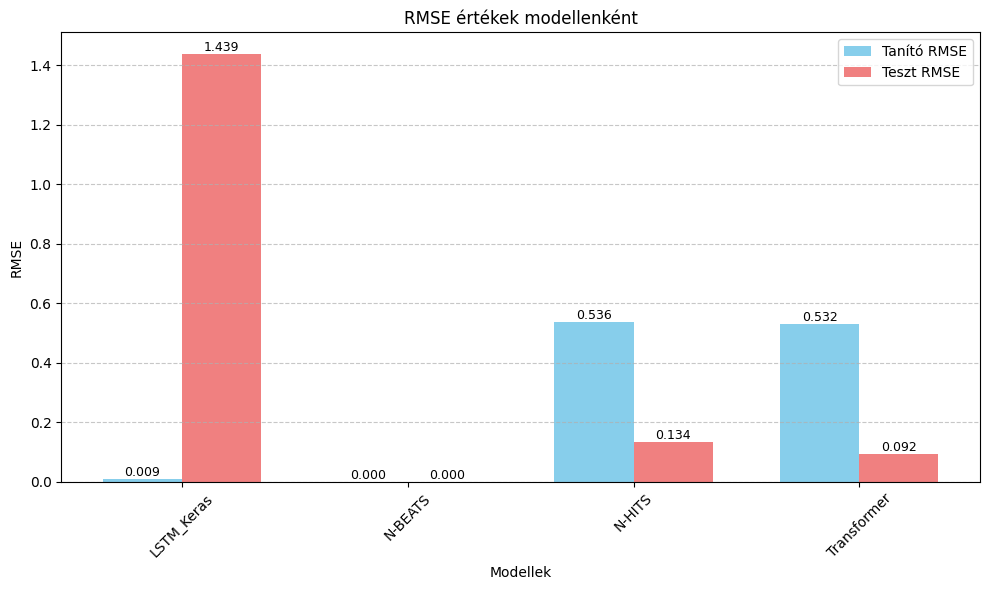

In [21]:
import matplotlib.pyplot as plt
import numpy as np

models = list(results.keys())
train_rmse = [results[model]['train_rmse'] for model in models]
val_rmse = [results[model]['test_rmse'] for model in models]

plt.figure(figsize=(10, 6))

x = np.arange(len(models))
width = 0.35  

bars1 = plt.bar(x - width/2, train_rmse, width, label='Tanító RMSE', color='skyblue')
bars2 = plt.bar(x + width/2, val_rmse, width, label='Teszt RMSE', color='lightcoral')

plt.xlabel('Modellek')
plt.ylabel('RMSE')
plt.title('RMSE értékek modellenként')
plt.xticks(x, models, rotation=45)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

for bar in bars1:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2, height,
        f'{height:.3f}',
        ha='center', va='bottom', fontsize=9
    )

for bar in bars2:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2, height,
        f'{height:.3f}',
        ha='center', va='bottom', fontsize=9
    )

plt.tight_layout()
plt.show()


In [22]:

conn = sqlite3.connect("../data_pipeline/stock_data.db")

stock_data = pd.read_sql("SELECT * FROM OTP_BD", conn)
conn.close()

print("Data read back from SQL:")
print()
stock_data

Data read back from SQL:



,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Scaled_price,sentiment_score
0,2002-03-05,1346.679102,1404.393921,1335.136138,1404.393921,1726700,0.0,0.0,-1.009421,0.0
1,2002-03-06,1396.057389,1443.511797,1379.384219,1436.457764,898300,0.0,0.0,-1.003618,0.0
2,2002-03-07,1449.924288,1474.934039,1437.098775,1471.727661,763700,0.0,0.0,-0.997235,0.0
3,2002-03-08,1452.489264,1463.390950,1438.381201,1462.108398,402000,0.0,0.0,-0.998976,1.0
4,2002-03-11,1445.435476,1448.641854,1379.384076,1384.514282,439600,0.0,0.0,-1.013019,1.0
...,...,...,...,...,...,...,...,...,...,...
6040,2025-10-15,30200.000000,30640.000000,30200.000000,30430.000000,333078,0.0,0.0,4.243485,2.0
6041,2025-10-16,30450.000000,30780.000000,30360.000000,30630.000000,290776,0.0,0.0,4.279680,1.0
6042,2025-10-17,30350.000000,30480.000000,30130.000000,30330.000000,268702,0.0,0.0,4.225388,2.0
6043,2025-10-20,30410.000000,30750.000000,30410.000000,30650.000000,166529,0.0,0.0,4.283300,0.0


In [24]:
test_set = stock_data[-90:]

test_X = test_set[["Scaled_price", "sentiment_score"]][:60].values

real_prices = test_set["Close"][-30:].values

test_set['time_idx'] = range(len(test_set))

test_set["series"] = 0

test_set['Sentiment_labels'] = test_set['sentiment_score'].map(SENTIMENT_LABEL_MAPPING)

common_params = dict(
    time_idx="time_idx",
    target="Scaled_price",
    categorical_encoders={"series": NaNLabelEncoder(add_nan=True).fit(stock_data.series)},
    group_ids=["series"],
    time_varying_unknown_reals=["Scaled_price"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    time_varying_unknown_categoricals=["Sentiment_labels"]
)

test_dataset = TimeSeriesDataSet(
    test_set,
    **common_params
)

test_dataloader = test_dataset.to_dataloader(train=False, batch_size=32, num_workers=0, shuffle=False)

C:\Users\veres\AppData\Local\Temp\ipykernel_13528\3778325258.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['time_idx'] = range(len(test_set))
C:\Users\veres\AppData\Local\Temp\ipykernel_13528\3778325258.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set["series"] = 0
C:\Users\veres\AppData\Local\Temp\ipykernel_13528\3778325258.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import joblib

# Define models
model_names = {
    "lstm": lstm_model,
    "nhits": nhits_model,
    "transformer": transformer_model
}

scaler = joblib.load("../data_pipeline/scaler_model.pkl")

test_predictions = {}
# test_actuals = {}

for name in model_names:
    if name == "lstm":
        test_pred = lstm_model.predict(test_X.reshape(1, 60, 2))
        test_predictions[name] = scaler.inverse_transform(test_pred)

    else:
        model = model_names[name]
        # print(model)
        test_pred = model.predict(test_dataloader).detach().numpy()

        test_predictions[name] = scaler.inverse_transform(test_pred)


NameError: name 'lstm_model' is not defined

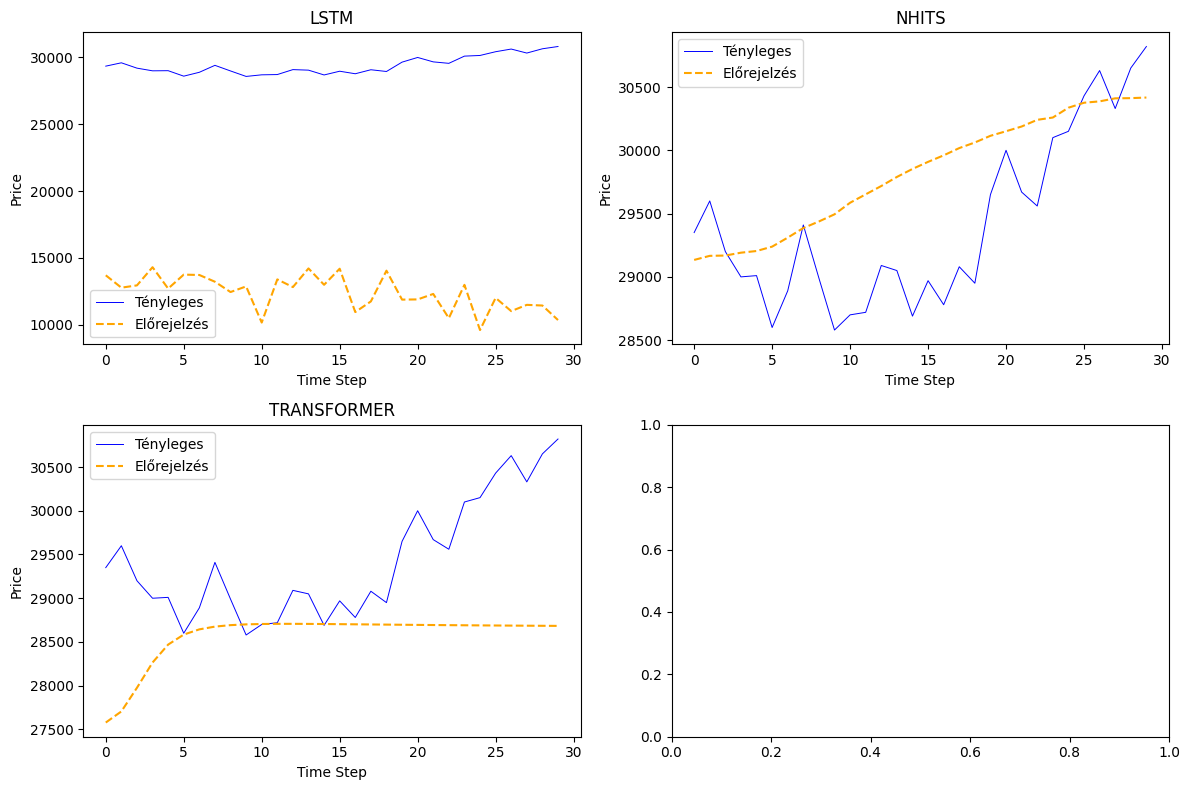


📊 Model Performance Comparison:
                      MSE      RMSE  MAPE (%)
Model                                        
LSTM         2.926228e+08  17106.22     57.77
NHITS        3.861753e+05    621.43      1.74
TRANSFORMER  1.222321e+06   1105.59      2.87


In [31]:
pred_df = pd.DataFrame({model: preds.flatten() for model, preds in test_predictions.items()})
pred_df['real'] = real_prices

# Plot each model vs real
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, (model, preds) in enumerate(test_predictions.items()):
    ax = axes[i]
    ax.plot(real_prices, label='Tényleges', color='blue', linewidth=0.7)
    ax.plot(preds.flatten(), label=f'Előrejelzés', color='orange', linestyle='--')
    ax.set_title(model.upper())
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Price')
    ax.legend()

plt.tight_layout()
plt.show()

# Calculate metrics
results = []
for model, preds in test_predictions.items():
    y_pred = preds.flatten()
    mse = mean_squared_error(real_prices, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(real_prices, y_pred) * 100
    results.append({'Model': model.upper(), 'MSE': mse, 'RMSE': rmse, 'MAPE (%)': mape})

# Create results table
results_df = pd.DataFrame(results).set_index('Model')
print("\n📊 Model Performance Comparison:")
print(results_df.round(2))

# TA+Szentiment Tanítás

In [83]:
import torch
from pytorch_forecasting.models.nbeats import NBeats
from pytorch_forecasting.models.nhits import NHiTS
from pytorch_forecasting.models.temporal_fusion_transformer import TemporalFusionTransformer
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.data.encoders import NaNLabelEncoder
from sklearn.preprocessing import StandardScaler
from pytorch_forecasting import TimeSeriesDataSet, NHiTS, NBeats, TemporalFusionTransformer
import sqlite3
import os
import mlflow
import pandas as pd
import numpy as np
import torch
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
from pytorch_forecasting.data import GroupNormalizer
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping as LSTMEarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import time

import numpy as np

import matplotlib.pyplot as plt



import yfinance as yf
import pandas_ta as ta

# Attempt to import TA-Lib
try:
    import talib
    TALIB_AVAILABLE = True
except ImportError:
    TALIB_AVAILABLE = False
    print("TA-Lib not found. Skipping pattern recognition features.")

try:
    from pytorch_forecasting.data.encoders import NaNLabelEncoder
except ImportError:
    print("Pytorch Forecasting not found. NaNLabelEncoder will be undefined.")
    class NaNLabelEncoder:
        def __init__(self, add_nan=False):
            pass
        def fit(self, series):
            return self

SENTIMENT_LABEL_MAPPING = {0 : "positive", 1 : "negative", 2: "neutral"}

In [84]:
conn = sqlite3.connect("../data_pipeline/stock_data.db")

stock_data = pd.read_sql("SELECT * FROM OTP_BD", conn)
conn.close()

print("Data read back from SQL:")
print()
stock_data

Data read back from SQL:



,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Scaled_price,sentiment_score
0,2002-03-05,1346.679102,1404.393921,1335.136138,1404.393921,1726700,0.0,0.0,-1.009421,0.0
1,2002-03-06,1396.057389,1443.511797,1379.384219,1436.457764,898300,0.0,0.0,-1.003618,0.0
2,2002-03-07,1449.924288,1474.934039,1437.098775,1471.727661,763700,0.0,0.0,-0.997235,0.0
3,2002-03-08,1452.489264,1463.390950,1438.381201,1462.108398,402000,0.0,0.0,-0.998976,1.0
4,2002-03-11,1445.435476,1448.641854,1379.384076,1384.514282,439600,0.0,0.0,-1.013019,1.0
...,...,...,...,...,...,...,...,...,...,...
6040,2025-10-15,30200.000000,30640.000000,30200.000000,30430.000000,333078,0.0,0.0,4.243485,2.0
6041,2025-10-16,30450.000000,30780.000000,30360.000000,30630.000000,290776,0.0,0.0,4.279680,1.0
6042,2025-10-17,30350.000000,30480.000000,30130.000000,30330.000000,268702,0.0,0.0,4.225388,2.0
6043,2025-10-20,30410.000000,30750.000000,30410.000000,30650.000000,166529,0.0,0.0,4.283300,0.0


In [85]:
stock_data['Sentiment_labels'] = stock_data['sentiment_score'].map(SENTIMENT_LABEL_MAPPING)

In [86]:
if TALIB_AVAILABLE:
    cdl_functions = [func for func in talib.get_function_groups()['Pattern Recognition'] if 'CDL' in func]
    # skip_funcs = ['CDLMATATHOLD', 'CDLXSIDEGAP3METHODS', 'CDLABANDONEDBABY']
    
    for func_name in cdl_functions:
        # if func_name in skip_funcs: continue
        try:
            col_name = f"CDL_{func_name[3:]}"
            stock_data[col_name] = getattr(talib, func_name)(
                stock_data['Open'], stock_data['High'], stock_data['Low'], stock_data['Close']
            )
        except Exception:
            pass

df = stock_data.dropna().copy()
df.reset_index(inplace=True)
df['time_idx'] = df.index

df["series"] = 0

all_cols = df.columns.tolist()
pattern_cols = [col for col in all_cols if col.startswith('CDL_')]

pattern_map = {
    -200: 'strong_bearish',
    -100: 'bearish',
    0: 'none',
    100: 'bullish',
    200: 'strong_bullish'
}

for col in pattern_cols:
    df[col] = df[col].map(pattern_map).fillna('none').astype('category')

exclude_cols = [
    'Date', 'Open', 'High', 'Low', 'Volume', 'Close', 'Adj Close',
    'time_idx',
    'series',  
    'Scaled_price',
    'Sentiment_labels',
] + pattern_cols

real_cols = [col for col in df.columns if col not in exclude_cols and col in df.select_dtypes(include=['number']).columns]

all_categorical_features = pattern_cols
if "Sentiment_labels" in df.columns:
     all_categorical_features.append("Sentiment_labels")

print(f"Found {len(pattern_cols)} pattern features.")
print(f"Found {len(real_cols)} other TA features (known reals).")
print(f"All categorical features: {all_categorical_features}")

categorical_encoders = {
    col: NaNLabelEncoder(add_nan=True).fit(df[col])
    for col in all_categorical_features
    if col in df.columns
}

max_encoder_length = 60
max_prediction_length = 30

common_params = dict(
    time_idx="time_idx",
    target="Scaled_price",
    group_ids=["series"],
    categorical_encoders=categorical_encoders,
    time_varying_known_reals=real_cols,
    time_varying_known_categoricals=pattern_cols,
    time_varying_unknown_reals=["Scaled_price"],
    time_varying_unknown_categoricals=["Sentiment_labels"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length
)

print("\n--- Final common_params ---")
import json
print(json.dumps(common_params, default=lambda o: str(o), indent=4))


train_cutoff = int(len(df) * 0.8)


train_val_data = df[df.time_idx <= train_cutoff]
test_data = df[df.time_idx > train_cutoff]


val_cutoff = int(train_val_data["time_idx"].quantile(0.9)) 

train_dataset = TimeSeriesDataSet(
    train_val_data[train_val_data.time_idx <= val_cutoff],
    **common_params
)

val_dataset = TimeSeriesDataSet.from_dataset(
    train_dataset,
    train_val_data[train_val_data.time_idx > val_cutoff],
    predict=True,
    stop_randomization=True
)

test_dataset = TimeSeriesDataSet.from_dataset(
    train_dataset,
    test_data,
    predict=True,
    stop_randomization=True
)


train_dataloader = train_dataset.to_dataloader(train=False, batch_size=32, num_workers=0, shuffle = False)
val_dataloader = val_dataset.to_dataloader(train=False, batch_size=32, num_workers=0, shuffle = False)
test_dataloader = test_dataset.to_dataloader(train=False, batch_size=32, num_workers=0, shuffle = False)


print("DataLoaders are ready.")
print(f"Train batches: {len(train_dataloader)}")
print(f"Validation batches: {len(val_dataloader)}")
print(f"Test batches: {len(test_dataloader)}")

Found 62 pattern features.
Found 4 other TA features (known reals).
All categorical features: ['CDL_2CROWS', 'CDL_3BLACKCROWS', 'CDL_3INSIDE', 'CDL_3LINESTRIKE', 'CDL_3OUTSIDE', 'CDL_3STARSINSOUTH', 'CDL_3WHITESOLDIERS', 'CDL_ABANDONEDBABY', 'CDL_ADVANCEBLOCK', 'CDL_BELTHOLD', 'CDL_BREAKAWAY', 'CDL_CLOSINGMARUBOZU', 'CDL_CONCEALBABYSWALL', 'CDL_COUNTERATTACK', 'CDL_DARKCLOUDCOVER', 'CDL_DOJI', 'CDL_DOJISTAR', 'CDL_DRAGONFLYDOJI', 'CDL_ENGULFING', 'CDL_EVENINGDOJISTAR', 'CDL_EVENINGSTAR', 'CDL_GAPSIDESIDEWHITE', 'CDL_GRAVESTONEDOJI', 'CDL_HAMMER', 'CDL_HANGINGMAN', 'CDL_HARAMI', 'CDL_HARAMICROSS', 'CDL_HIGHWAVE', 'CDL_HIKKAKE', 'CDL_HIKKAKEMOD', 'CDL_HOMINGPIGEON', 'CDL_IDENTICAL3CROWS', 'CDL_INNECK', 'CDL_INVERTEDHAMMER', 'CDL_KICKING', 'CDL_KICKINGBYLENGTH', 'CDL_LADDERBOTTOM', 'CDL_LONGLEGGEDDOJI', 'CDL_LONGLINE', 'CDL_MARUBOZU', 'CDL_MATCHINGLOW', 'CDL_MATHOLD', 'CDL_MORNINGDOJISTAR', 'CDL_MORNINGSTAR', 'CDL_ONNECK', 'CDL_PIERCING', 'CDL_RICKSHAWMAN', 'CDL_RISEFALL3METHODS', 'CDL_SE

In [87]:

categorical_features_to_encode = pattern_cols[:]

if "Sentiment_labels" in df.columns:
     categorical_features_to_encode.append("Sentiment_labels")

print(f"Original df shape: {df.shape}")
print(f"Encoding {len(categorical_features_to_encode)} categorical features...")
df_encoded = pd.get_dummies(df, columns=categorical_features_to_encode)
print(f"New encoded df shape: {df_encoded.shape}")


one_hot_cols = [
    col for col in df_encoded.columns 
    if any(col.startswith(prefix) for prefix in categorical_features_to_encode)
]

feature_columns = real_cols + one_hot_cols + ['Scaled_price']

feature_columns = [col for col in feature_columns if col in df_encoded.columns]

data_features = df_encoded[feature_columns].values.astype('float32')
target_column = df_encoded['Scaled_price'].values

total_len = len(data_features)

n_features = data_features.shape[1]

train_split_pct = 0.7
validation_split_pct = 0.1

train_cutoff = int(total_len * train_split_pct)
validation_cutoff = int(total_len * (train_split_pct + validation_split_pct))

print(f"Total data length: {total_len}")
print(f"Training data:   indices 0 to {train_cutoff}")
print(f"Validation data: indices {train_cutoff} to {validation_cutoff}")
print(f"Test data:       indices {validation_cutoff} to {total_len}")



def create_sequences(input_data, output_data, start_idx, end_idx):
    X, y = [], []
    end_idx = min(end_idx, len(input_data))
    
    # Adjust start_idx to account for encoder length
    actual_start = start_idx + max_encoder_length
    
    for i in range(actual_start, end_idx - max_prediction_length):
        X.append(input_data[i - max_encoder_length:i, :]) 
        y.append(output_data[i:i + max_prediction_length])
        
    if not X:
        print(f"Warning: No sequences created for range {start_idx}-{end_idx}.")
        return np.array([]), np.array([])
        
    return np.array(X), np.array(y)

print("Creating training sequences...")
train_X, train_y = create_sequences(data_features, target_column, 0, train_cutoff)

print("Creating validation sequences...")
val_X, val_y = create_sequences(data_features, target_column, train_cutoff, validation_cutoff)

print("Creating testing sequences...")
test_X, test_y = create_sequences(data_features, target_column, validation_cutoff, total_len)

if train_X.shape[0] > 0 and val_X.shape[0] > 0 and test_X.shape[0] > 0:
    print(f"Train X shape: {train_X.shape}, Train y shape: {train_y.shape}")
    print(f"Val X shape:   {val_X.shape}, Val y shape:   {val_y.shape}")
    print(f"Test X shape:  {test_X.shape}, Test y shape:  {test_y.shape}")

    lstm_model = Sequential([
        Input(shape=(max_encoder_length, n_features)),
        
        LSTM(units=128, return_sequences=True, recurrent_dropout=0.2),
        Dropout(0.3),
        
        LSTM(units=128, return_sequences=True, recurrent_dropout=0.2),
        Dropout(0.3),
        
        LSTM(units=64, recurrent_dropout=0.2), 
        Dropout(0.3),
        
        Dense(64, activation='relu'),
        Dropout(0.3),
        
        Dense(max_prediction_length, activation='linear')
    ])

    lstm_model.summary()

    optimizer = Adam(learning_rate=0.0001) 

    lstm_model.compile(optimizer=optimizer, loss='mean_squared_error')
else:
    print("Error: Not enough data to create train/test sequences. Model not built.")
    print(f"Total data length: {len(data_features)}")
    print(f"Min length required: {max_encoder_length + max_prediction_length + 1}")

Original df shape: (6045, 75)
Encoding 63 categorical features...
New encoded df shape: (6045, 160)
Total data length: 6045
Training data:   indices 0 to 4231
Validation data: indices 4231 to 4836
Test data:       indices 4836 to 6045
Creating training sequences...
Creating validation sequences...
Creating testing sequences...
Train X shape: (4141, 60, 158), Train y shape: (4141, 30)
Val X shape:   (515, 60, 158), Val y shape:   (515, 30)
Test X shape:  (1119, 60, 158), Test y shape:  (1119, 30)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_27 (LSTM)                  │ (None, 60, 128)        │       146,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_28 (LSTM)                  │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_29 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 30)             │         1,950 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 334,046 (1.27 MB)

 Trainable params: 334,046 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

In [89]:
mlflow.set_tracking_uri('http://localhost:5000')

mlflow.set_experiment("Base_models_ta_sentiment")

models = {
    "LSTM_Keras": None,
    # "N-BEATS": NBeats,
    "N-HITS": NHiTS,
    "Transformer": TemporalFusionTransformer
}

results = {}

test_actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])

for model_name, model_class in models.items():
    with mlflow.start_run(run_name=model_name):
        print(f"\n=== Training {model_name} ===")
        if model_name == "LSTM_Keras":
            early_stopping = LSTMEarlyStopping(
                monitor='val_loss', 
                patience=10, 
                restore_best_weights=True 
            )

            reduce_lr = ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2, 
                patience=5
            )
            history = lstm_model.fit(
                train_X, 
                train_y,
                epochs=100,
                batch_size=32,
                validation_data=(val_X, val_y),
                callbacks=[early_stopping, reduce_lr],
                shuffle=False
            )

            train_pred = lstm_model.predict(train_X)
            train_rmse = mean_squared_error(train_y, train_pred)

            test_pred = lstm_model.predict(test_X)
            test_rmse = mean_squared_error(test_y, test_pred)

            mlflow.log_metric("train_rmse", train_rmse)
            mlflow.log_metric("test_rmse", test_rmse)
            mlflow.keras.log_model(lstm_model, "model")
            results[model_name] = {'train_rmse': train_rmse, 'test_rmse': test_rmse}
            lstm_model.save('models/lstm_model_ta_sentiment.keras')
        
        elif model_name == "N-BEATS":
        #     nbeats_model = NBeats.from_dataset(  
        #         train_dataset,  
        #         learning_rate=1e-3,  
        #         weight_decay=1e-3,  
        #         widths=[256, 512],  
        #         backcast_loss_ratio=0.1,  
        #         num_blocks=[4,4],  
        #         num_block_layers=[4,4], 
        #     )
        #     trainer = Trainer(max_epochs=20, gradient_clip_val=0.1, logger=False, enable_checkpointing=False)
        #     trainer.fit(nbeats_model, train_dataloader)

        #     actuals = torch.cat([y[0] for x, y in iter(train_dataloader)])
        #     predictions = nbeats_model.predict(train_dataloader)
        #     train_rmse = root_mean_squared_error(actuals, predictions[:len(actuals)])

        #     test_actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
        #     test_predictions = nbeats_model.predict(val_dataloader)
        #     test_rmse = root_mean_squared_error(test_actuals, test_predictions[:len(test_actuals)])

        #     test_mse = mean_squared_error(test_actuals, test_predictions[:len(test_actuals)])

        #     test_mape = mean_absolute_percentage_error(test_actuals, test_predictions[:len(test_actuals)])

        #     total_params = sum(p.numel() for p in nbeats_model.parameters() if p.requires_grad)

        #     mlflow.log_metric("train_rmse", train_rmse)
        #     mlflow.log_metric("test_rmse", test_rmse)
        #     mlflow.log_metric("test_mse", test_mse)
        #     mlflow.log_metric("test_mape", test_mape)
        #     mlflow.log_metric("total_parameters", total_params)
        #     mlflow.pytorch.log_model(nbeats_model, "model")
            results[model_name] = {'train_rmse': 0, 'test_rmse': 0}
        #     torch.save(nbeats_model.state_dict(), "models/nbeats_weights_sentiment.pth")

        elif model_name == "N-HITS":
            nhits_model = NHiTS.from_dataset(
                train_dataset,
                learning_rate=1e-3,  
                log_interval=10,  
                log_val_interval=1,  
                weight_decay=0.001,  
                n_blocks=[3, 3, 3],  
                n_layers=2,  
                hidden_size=512,  
                dropout=0.1,  
            )
            early_stopping = EarlyStopping(
                monitor="val_loss",          
                patience=20,                 
                min_delta=1e-4,              
                mode="min", 
                verbose=True
            )
            trainer = Trainer(
                max_epochs=100,
                gradient_clip_val=0.1,
                logger=False,
                enable_checkpointing=False,
                callbacks=[early_stopping]  
            )
            trainer.fit(nhits_model, train_dataloader, val_dataloader)

            actuals = torch.cat([y[0] for x, y in iter(train_dataloader)])
            predictions = nhits_model.predict(train_dataloader)

            test_actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
            test_predictions = nhits_model.predict(test_dataloader)

            train_rmse = root_mean_squared_error(actuals, predictions[:len(actuals)])
            test_rmse = root_mean_squared_error(test_actuals, test_predictions[:len(test_actuals)])

            test_mse = mean_squared_error(test_actuals, test_predictions[:len(test_actuals)])

            test_mape = mean_absolute_percentage_error(test_actuals, test_predictions[:len(test_actuals)])

            total_params = sum(p.numel() for p in nhits_model.parameters() if p.requires_grad)

            mlflow.log_metric("train_rmse", train_rmse)
            mlflow.log_metric("test_rmse", test_rmse)
            mlflow.log_metric("test_mse", test_mse)
            mlflow.log_metric("test_mape", test_mape)
            mlflow.log_metric("total_parameters", total_params)
            mlflow.pytorch.log_model(nhits_model, "model")
            results[model_name] = {'train_rmse': train_rmse, 'test_rmse': test_rmse}
            torch.save(nhits_model.state_dict(), "models/nhits_weights_ta_sentiment.pth")

        else:
            transformer_model = TemporalFusionTransformer.from_dataset(
                train_dataset,
                hidden_size=64,
                lstm_layers=1,
                dropout=0.15,
                attention_head_size=4,
                learning_rate=1e-3
            )
            early_stopping = EarlyStopping(
                monitor="val_loss",          
                patience=20,                 
                min_delta=1e-4,              
                mode="min", 
                verbose=True
            )
            trainer = Trainer(
                max_epochs=100,
                gradient_clip_val=0.1,
                logger=False,
                enable_checkpointing=False,
                callbacks=[early_stopping]  
            )
            trainer.fit(transformer_model, train_dataloader, val_dataloader)

            actuals = torch.cat([y[0] for x, y in iter(train_dataloader)])
            predictions = transformer_model.predict(train_dataloader)

            test_actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
            test_predictions = transformer_model.predict(test_dataloader)

            train_rmse = root_mean_squared_error(actuals, predictions[:len(actuals)])
            test_rmse = root_mean_squared_error(test_actuals, test_predictions[:len(test_actuals)])

            test_mse = mean_squared_error(test_actuals, test_predictions[:len(test_actuals)])

            test_mape = mean_absolute_percentage_error(test_actuals, test_predictions[:len(test_actuals)])

            total_params = sum(p.numel() for p in transformer_model.parameters() if p.requires_grad)

            mlflow.log_metric("train_rmse", train_rmse)
            mlflow.log_metric("test_rmse", test_rmse)
            mlflow.log_metric("test_mse", test_mse)
            mlflow.log_metric("test_mape", test_mape)
            mlflow.log_metric("total_parameters", total_params)
            mlflow.pytorch.log_model(transformer_model, "model")
            results[model_name] = {'train_rmse': train_rmse, 'test_rmse': test_rmse}
            torch.save(transformer_model.state_dict(), "models/transformer_weights_ta_sentiment.pth")

print("\n=== RMSE Results ===")
for model_name, rmse_values in results.items():
    print(f"{model_name} => Train RMSE: {rmse_values['train_rmse']:.4f}, Test RMSE: {rmse_values['test_rmse']:.4f}")



=== Training LSTM_Keras ===
Epoch 1/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 13s 103ms/step - loss: 0.2762 - val_loss: 0.6876 - learning_rate: 4.0000e-06
Epoch 2/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 13s 103ms/step - loss: 0.2555 - val_loss: 0.7402 - learning_rate: 4.0000e-06
Epoch 3/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 13s 103ms/step - loss: 0.2460 - val_loss: 0.7799 - learning_rate: 4.0000e-06
Epoch 4/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 14s 104ms/step - loss: 0.2388 - val_loss: 0.8135 - learning_rate: 4.0000e-06
Epoch 5/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - loss: 0.2326 - val_loss: 0.8420 - learning_rate: 4.0000e-06
Epoch 6/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - loss: 0.2290 - val_loss: 0.8638 - learning_rate: 4.0000e-06
Epoch 7/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 14s 104ms/step - loss: 0.2274 - val_loss: 0.8679 - learning_rate: 8.0000e-07
Epoch 8/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - loss: 0.2264 - val_loss: 0.8720 - learning_rate: 8.0000e-07
Epoch 9/100
130/130 ━━━━━━━

2025/11/08 21:04:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/08 21:04:53 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/11/08 21:04:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LSTM_Keras at: http://localhost:5000/#/experiments/845260606633882962/runs/6d71c22bd97f4afe8d8b481ab6b779d5
🧪 View experiment at: http://localhost:5000/#/experiments/845260606633882962

=== Training N-HITS ===


c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs

  | Name            | Type           | Params | Mode 
-----------------------------------------------------------
0 | loss            | MASE           | 0      | train
1 | log

c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 134/134 [00:52<00:00,  2.56it/s, train_loss_step=6.200, val_loss=3.980, train_loss_epoch=11.50]

Metric val_loss improved. New best score: 3.975


Epoch 1: 100%|██████████| 134/134 [00:52<00:00,  2.57it/s, train_loss_step=3.450, val_loss=3.660, train_loss_epoch=4.310]

Metric val_loss improved by 0.313 >= min_delta = 0.0001. New best score: 3.663


Epoch 2: 100%|██████████| 134/134 [00:51<00:00,  2.58it/s, train_loss_step=3.840, val_loss=3.140, train_loss_epoch=4.330]

Metric val_loss improved by 0.524 >= min_delta = 0.0001. New best score: 3.138


Epoch 22: 100%|██████████| 134/134 [00:51<00:00,  2.62it/s, train_loss_step=2.720, val_loss=3.630, train_loss_epoch=3.900]

Monitored metric val_loss did not improve in the last 20 records. Best score: 3.138. Signaling Trainer to stop.


Epoch 22: 100%|██████████| 134/134 [00:51<00:00,  2.62it/s, train_loss_step=2.720, val_loss=3.630, train_loss_epoch=3.900]


c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
2025/11/08 21:25:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/08 21:25:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\utilities\

🏃 View run N-HITS at: http://localhost:5000/#/experiments/845260606633882962/runs/4aea10e4c7f442af9c154dbb6bc9ae1d
🧪 View experiment at: http://localhost:5000/#/experiments/845260606633882962

=== Training Transformer ===
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 134/134 [00:50<00:00,  2.65it/s, train_loss_step=0.0385, val_loss=0.121, train_loss_epoch=0.0406]

Metric val_loss improved. New best score: 0.121


Epoch 1: 100%|██████████| 134/134 [00:50<00:00,  2.67it/s, train_loss_step=0.0397, val_loss=0.118, train_loss_epoch=0.0395]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.118


Epoch 10: 100%|██████████| 134/134 [00:54<00:00,  2.48it/s, train_loss_step=0.0465, val_loss=0.115, train_loss_epoch=0.0376]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.115


Epoch 11: 100%|██████████| 134/134 [00:53<00:00,  2.51it/s, train_loss_step=0.0456, val_loss=0.109, train_loss_epoch=0.0372]

Metric val_loss improved by 0.006 >= min_delta = 0.0001. New best score: 0.109


Epoch 12: 100%|██████████| 134/134 [00:52<00:00,  2.55it/s, train_loss_step=0.0442, val_loss=0.109, train_loss_epoch=0.0369]

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.109


Epoch 13: 100%|██████████| 134/134 [00:52<00:00,  2.57it/s, train_loss_step=0.0446, val_loss=0.105, train_loss_epoch=0.0363]

Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 0.105


Epoch 14: 100%|██████████| 134/134 [00:52<00:00,  2.57it/s, train_loss_step=0.0456, val_loss=0.0981, train_loss_epoch=0.0355]

Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 0.098


Epoch 15: 100%|██████████| 134/134 [00:52<00:00,  2.57it/s, train_loss_step=0.045, val_loss=0.097, train_loss_epoch=0.0352]  

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.097


Epoch 17: 100%|██████████| 134/134 [00:51<00:00,  2.59it/s, train_loss_step=0.0493, val_loss=0.0953, train_loss_epoch=0.0358]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.095


Epoch 21: 100%|██████████| 134/134 [00:51<00:00,  2.59it/s, train_loss_step=0.0291, val_loss=0.0858, train_loss_epoch=0.0266]

Metric val_loss improved by 0.009 >= min_delta = 0.0001. New best score: 0.086


Epoch 22: 100%|██████████| 134/134 [00:51<00:00,  2.58it/s, train_loss_step=0.0296, val_loss=0.0785, train_loss_epoch=0.0249] 

Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 0.078


Epoch 23: 100%|██████████| 134/134 [00:51<00:00,  2.60it/s, train_loss_step=0.0277, val_loss=0.0554, train_loss_epoch=0.024]  

Metric val_loss improved by 0.023 >= min_delta = 0.0001. New best score: 0.055


Epoch 26: 100%|██████████| 134/134 [00:52<00:00,  2.54it/s, train_loss_step=0.0231, val_loss=0.0487, train_loss_epoch=0.022]  

Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 0.049


Epoch 29: 100%|██████████| 134/134 [00:54<00:00,  2.45it/s, train_loss_step=0.0199, val_loss=0.0474, train_loss_epoch=0.0198] 

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.047


Epoch 32: 100%|██████████| 134/134 [00:53<00:00,  2.51it/s, train_loss_step=0.017, val_loss=0.0366, train_loss_epoch=0.0184]  

Metric val_loss improved by 0.011 >= min_delta = 0.0001. New best score: 0.037


Epoch 52: 100%|██████████| 134/134 [00:54<00:00,  2.47it/s, train_loss_step=0.0118, val_loss=0.0539, train_loss_epoch=0.0126] 

Monitored metric val_loss did not improve in the last 20 records. Best score: 0.037. Signaling Trainer to stop.


Epoch 52: 100%|██████████| 134/134 [00:54<00:00,  2.47it/s, train_loss_step=0.0118, val_loss=0.0539, train_loss_epoch=0.0126]


c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
2025/11/08 22:14:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/08 22:14:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Transformer at: http://localhost:5000/#/experiments/845260606633882962/runs/9a2e0ac1ea324facad11606f4a3c55d6
🧪 View experiment at: http://localhost:5000/#/experiments/845260606633882962

=== RMSE Results ===
LSTM_Keras => Train RMSE: 0.2366, Test RMSE: 3.9921
N-HITS => Train RMSE: 0.0604, Test RMSE: 0.1202
Transformer => Train RMSE: 0.0345, Test RMSE: 0.1835


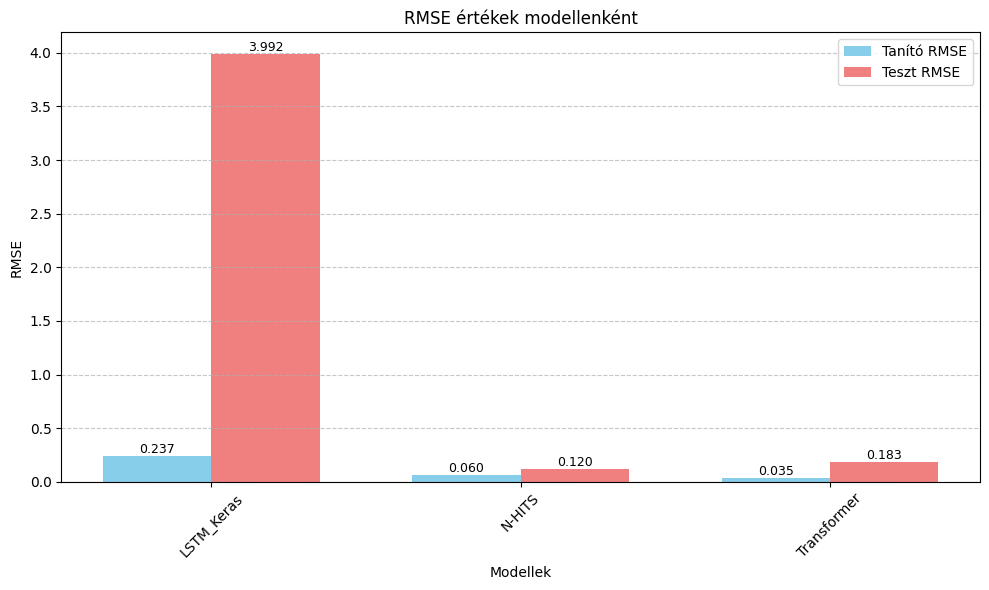

In [90]:
models = list(results.keys())
train_rmse = [results[model]['train_rmse'] for model in models]
val_rmse = [results[model]['test_rmse'] for model in models]

plt.figure(figsize=(10, 6))

x = np.arange(len(models))
width = 0.35  

bars1 = plt.bar(x - width/2, train_rmse, width, label='Tanító RMSE', color='skyblue')
bars2 = plt.bar(x + width/2, val_rmse, width, label='Teszt RMSE', color='lightcoral')

plt.xlabel('Modellek')
plt.ylabel('RMSE')
plt.title('RMSE értékek modellenként')
plt.xticks(x, models, rotation=45)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

for bar in bars1:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2, height,
        f'{height:.3f}',
        ha='center', va='bottom', fontsize=9
    )

for bar in bars2:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2, height,
        f'{height:.3f}',
        ha='center', va='bottom', fontsize=9
    )

plt.tight_layout()
plt.show()

## Modell tesztelés

In [91]:
conn = sqlite3.connect("../data_pipeline/stock_data.db")

stock_data = pd.read_sql("SELECT * FROM OTP_BD", conn)
conn.close()

print("Data read back from SQL:")
print()
stock_data

Data read back from SQL:



,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Scaled_price,sentiment_score
0,2002-03-05,1346.679102,1404.393921,1335.136138,1404.393921,1726700,0.0,0.0,-1.009421,0.0
1,2002-03-06,1396.057389,1443.511797,1379.384219,1436.457764,898300,0.0,0.0,-1.003618,0.0
2,2002-03-07,1449.924288,1474.934039,1437.098775,1471.727661,763700,0.0,0.0,-0.997235,0.0
3,2002-03-08,1452.489264,1463.390950,1438.381201,1462.108398,402000,0.0,0.0,-0.998976,1.0
4,2002-03-11,1445.435476,1448.641854,1379.384076,1384.514282,439600,0.0,0.0,-1.013019,1.0
...,...,...,...,...,...,...,...,...,...,...
6040,2025-10-15,30200.000000,30640.000000,30200.000000,30430.000000,333078,0.0,0.0,4.243485,2.0
6041,2025-10-16,30450.000000,30780.000000,30360.000000,30630.000000,290776,0.0,0.0,4.279680,1.0
6042,2025-10-17,30350.000000,30480.000000,30130.000000,30330.000000,268702,0.0,0.0,4.225388,2.0
6043,2025-10-20,30410.000000,30750.000000,30410.000000,30650.000000,166529,0.0,0.0,4.283300,0.0


In [92]:
stock_data['Sentiment_labels'] = stock_data['sentiment_score'].map(SENTIMENT_LABEL_MAPPING)

In [93]:
if TALIB_AVAILABLE:
    cdl_functions = [func for func in talib.get_function_groups()['Pattern Recognition'] if 'CDL' in func]
    
    for func_name in cdl_functions:
        try:
            col_name = f"CDL_{func_name[3:]}"
            stock_data[col_name] = getattr(talib, func_name)(
                stock_data['Open'], stock_data['High'], stock_data['Low'], stock_data['Close']
            )
        except Exception:
            pass

df = stock_data.dropna().copy()
df.reset_index(inplace=True)
df['time_idx'] = df.index
df["series"] = 0 


all_cols = df.columns.tolist()
pattern_cols = [col for col in all_cols if col.startswith('CDL_')]

pattern_map = {
    -200: 'strong_bearish',
    -100: 'bearish',
    0: 'none',
    100: 'bullish',
    200: 'strong_bullish'
}
for col in pattern_cols:
    df[col] = df[col].map(pattern_map).fillna('none').astype('category')


exclude_cols = [
    'Date', 'Open', 'High', 'Low', 'Volume', 'Close', 'Adj Close',
    'time_idx',
    'series', 
    'Scaled_price',
    'Sentiment_labels',
] + pattern_cols

real_cols = [col for col in df.columns if col not in exclude_cols and col in df.select_dtypes(include=['number']).columns]

all_categorical_features = pattern_cols
if "Sentiment_labels" in df.columns:
     all_categorical_features.append("Sentiment_labels")


categorical_encoders = {
    col: NaNLabelEncoder(add_nan=True).fit(df[col])
    for col in all_categorical_features
    if col in df.columns
}

max_encoder_length = 60
max_prediction_length = 30

common_params = dict(
    time_idx="time_idx",
    target="Scaled_price",
    group_ids=["series"],
    categorical_encoders=categorical_encoders,
    time_varying_known_reals=real_cols,
    time_varying_known_categoricals=pattern_cols,
    time_varying_unknown_reals=["Scaled_price"],
    time_varying_unknown_categoricals=["Sentiment_labels"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length
)


test_data = df.iloc[-90:].copy()

train_val_data = df.iloc[:-90].copy()

val_cutoff_time_idx = int(train_val_data["time_idx"].quantile(0.9))

test_dataset = TimeSeriesDataSet(
    test_data,
    **common_params
)



test_dataloader = test_dataset.to_dataloader(train=False, batch_size=32, num_workers=0)

In [94]:
categorical_features_to_encode = pattern_cols[:]

if "Sentiment_labels" in df.columns:
     categorical_features_to_encode.append("Sentiment_labels")

print(f"Original df shape: {df.shape}")
print(f"Encoding {len(categorical_features_to_encode)} categorical features...")
df_encoded = pd.get_dummies(df, columns=categorical_features_to_encode)
print(f"New encoded df shape: {df_encoded.shape}")


one_hot_cols = [
    col for col in df_encoded.columns 
    if any(col.startswith(prefix) for prefix in categorical_features_to_encode)
]

feature_columns = real_cols + one_hot_cols + ['Scaled_price']

feature_columns = [col for col in feature_columns if col in df_encoded.columns]

data_features = df_encoded[feature_columns].values.astype('float32')
real_prices = df_encoded["Close"][-30:].values

Original df shape: (6045, 75)
Encoding 63 categorical features...
New encoded df shape: (6045, 160)


In [95]:
len(feature_columns)

152

In [96]:
data_features = data_features[-90:]
n_features = data_features.shape[1]

In [97]:
test_X = data_features[:60]

In [98]:
n_features

158

In [99]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import joblib

# Define models
model_names = {
    "lstm": lstm_model,
    "nhits": nhits_model,
    "transformer": transformer_model
}

scaler = joblib.load("../data_pipeline/scaler_model.pkl")

test_predictions = {}
# test_actuals = {}

for name in model_names:
    if name == "lstm":
        test_pred = lstm_model.predict(test_X.reshape(1, 60, n_features))
        test_predictions[name] = scaler.inverse_transform(test_pred)

    else:
        model = model_names[name]
        # print(model)
        test_pred = model.predict(test_dataloader).detach().numpy()

        test_predictions[name] = scaler.inverse_transform(test_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\veres\Documents\Diplomamunka\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


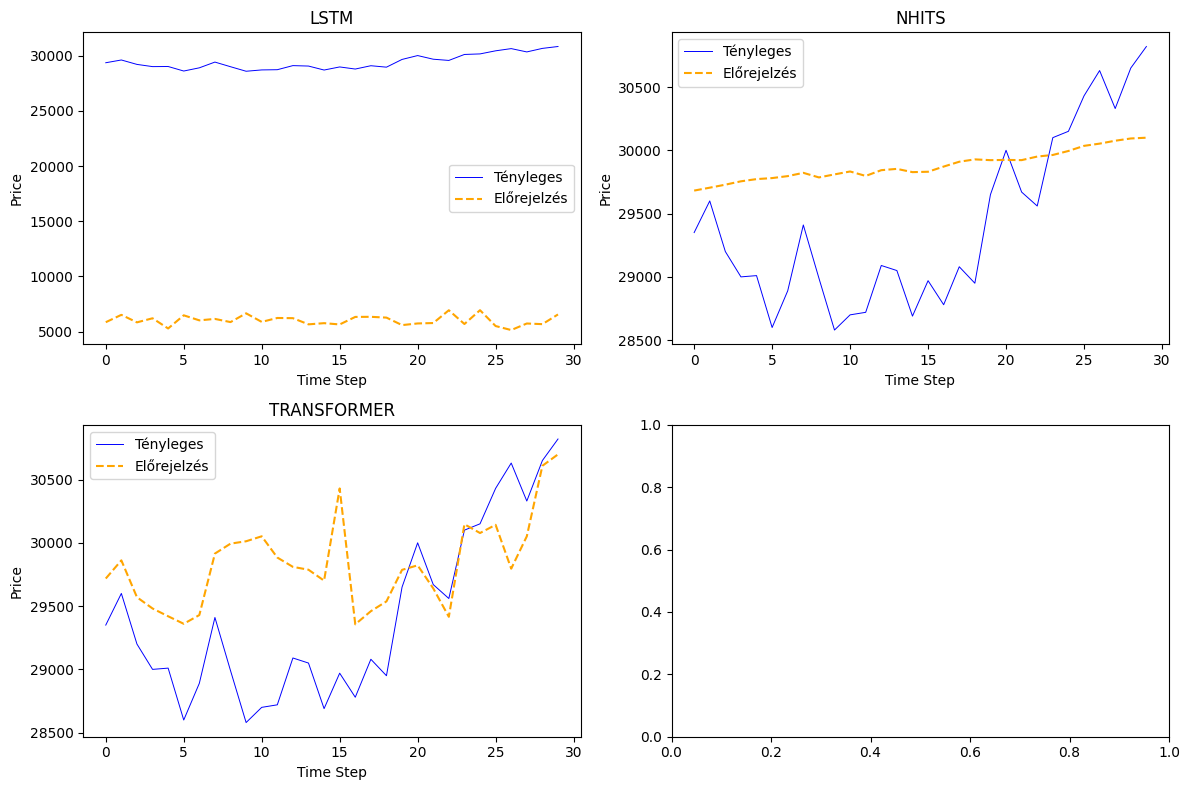


📊 Model Performance Comparison:
                      MSE      RMSE  MAPE (%)
Model                                        
LSTM         5.483821e+08  23417.56     79.52
NHITS        5.443564e+05    737.81      2.22
TRANSFORMER  4.696148e+05    685.28      1.87


In [100]:
pred_df = pd.DataFrame({model: preds.flatten() for model, preds in test_predictions.items()})
pred_df['real'] = real_prices

# Plot each model vs real
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, (model, preds) in enumerate(test_predictions.items()):
    ax = axes[i]
    ax.plot(real_prices, label='Tényleges', color='blue', linewidth=0.7)
    ax.plot(preds.flatten(), label=f'Előrejelzés', color='orange', linestyle='--')
    ax.set_title(model.upper())
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Price')
    ax.legend()

plt.tight_layout()
plt.show()

# Calculate metrics
results = []
for model, preds in test_predictions.items():
    y_pred = preds.flatten()
    mse = mean_squared_error(real_prices, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(real_prices, y_pred) * 100
    results.append({'Model': model.upper(), 'MSE': mse, 'RMSE': rmse, 'MAPE (%)': mape})

# Create results table
results_df = pd.DataFrame(results).set_index('Model')
print("\n📊 Model Performance Comparison:")
print(results_df.round(2))

lstm
[23494.40478516 23077.46777344 23357.64257812 22788.59423828
 23721.92236328 22120.51220703 22866.27587891 23256.77148438
 23123.12548828 21920.12207031 22815.28759766 22480.85107422
 22868.40625    23387.7109375  22920.72070312 23316.45507812
 22445.05615234 22736.1640625  22677.60351562 24056.53759766
 24256.78564453 23890.30615234 22621.87109375 24407.10986328
 23206.70361328 24921.66162109 25483.8046875  24591.07617188
 24969.85498047 24260.60302734]
{'lstm': array([23494.40478516, 23077.46777344, 23357.64257812, 22788.59423828,
       23721.92236328, 22120.51220703, 22866.27587891, 23256.77148438,
       23123.12548828, 21920.12207031, 22815.28759766, 22480.85107422,
       22868.40625   , 23387.7109375 , 22920.72070312, 23316.45507812,
       22445.05615234, 22736.1640625 , 22677.60351562, 24056.53759766,
       24256.78564453, 23890.30615234, 22621.87109375, 24407.10986328,
       23206.70361328, 24921.66162109, 25483.8046875 , 24591.07617188,
       24969.85498047, 24260.6

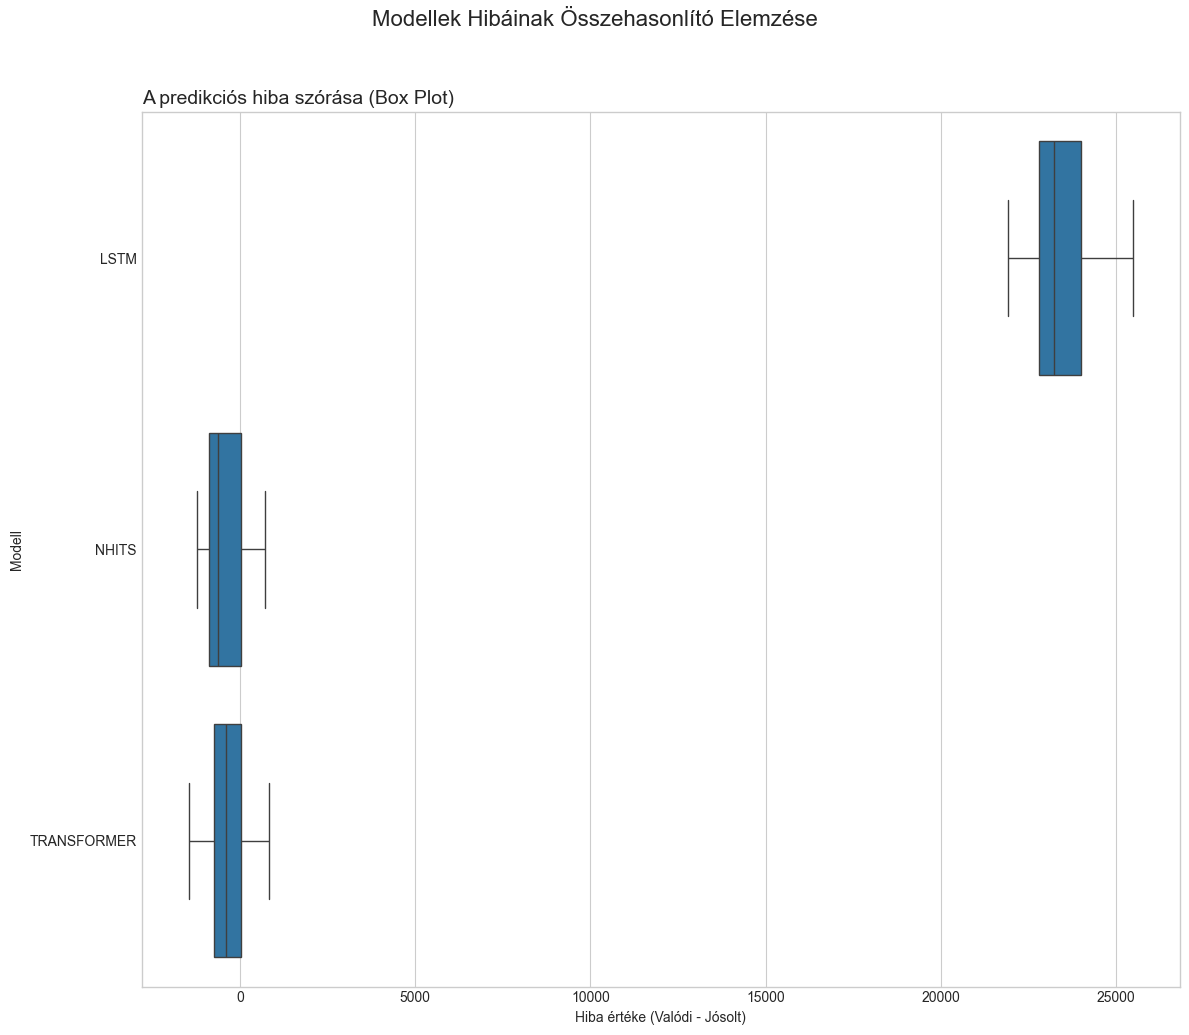

In [ ]:
import seaborn as sns

errors_dict = {}
for model, preds in test_predictions.items():
    print(model)
    y_pred = preds.flatten()
    if len(y_pred) != len(real_prices):
        print(f"Figyelem: A '{model}' predikciók hossza ({len(y_pred)}) nem egyezik a valós árak hosszával ({len(real_prices)})")
        continue

    error = real_prices - y_pred
    print(error)
    errors_dict[model] = error
    print(errors_dict)

print(errors_dict)
print("\n--- Hibaelemzési Statisztikák ---")
print(f"{'Modell':<12} | {'Átlagos Hiba (ME)':<20} | {'Hiba Szórása (Std)':<20}")
print("-" * 57)

stats_data = []
for model_name, errors in errors_dict.items():
    mean_error = np.mean(errors)
    std_error = np.std(errors)
    
    print(f"{model_name:<12} | {mean_error:<20.4f} | {std_error:<20.4f}")
    
    for error in errors:
        stats_data.append({'Hiba': error, 'Modell': model_name.upper()})


if not stats_data:
    raise ValueError("Nem sikerült hibastatisztikát generálni. Ellenőrizze az adatokat.")

df_errors = pd.DataFrame(stats_data)

print("\nÁbra generálása...")

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax1 = plt.subplots(
    nrows=1, 
    ncols=1, 
    figsize=(12, 10),
    sharex=True
)

sns.boxplot(data=df_errors, x='Hiba', y='Modell', ax=ax1, orient='h')
ax1.set_title('A predikciós hiba szórása (Box Plot)', fontsize=14, loc='left')
ax1.set_xlabel('Hiba értéke (Valódi - Jósolt)')
ax1.set_ylabel('Modell')


plt.suptitle('Modellek Hibáinak Összehasonlító Elemzése', fontsize=16, y=1.03)
plt.tight_layout()


plt.show()